# **3. ERF Analysis**

In this notebook traditional Event-related field (ERF) analyses are performed, divided into 4 major sections:
1. GLM copes (Generalized Linear Model - Contrast of Parameter Estimates)
2. Traditional ERF analyses 
3. Amplitude/Latency study
4. Covariate: BRUMEG1 vs. BRUMEG2

#### **<font color='red'> Note**: <font color='black'> This Notebook only uses preprocessed data **without** orthogonalisation & **without** sign-flipping 
    
#### **<font color='red'> Note**: <font color='black'> Select only the **first 128 trials** for any epoching and trial-averaging

### **Required input files/folders to run this Notebook**:
- **DIR_parceled_raw**: folder with all fully processed .fif files (from Notebook 1. Preprocessing MEG Python) --> Needed in order to extract event timestamps
- **Parcels_38_names.txt**: .txt file with the names of the 38 parcels of the parcellation file
- **subjectinfo.mat**: file with all clinical patient information 

#### **Import needed packages**

In [ ]:
import numpy as np
import pandas as pd
import mne

import os
import glob

import scipy 
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt

import osl

import os
import pickle
from copy import deepcopy

import glmtools as glm
import mne
import numpy as np
import glmtools.design as glm_design


#To clear unnecessary outputs in the cell that take up space
from IPython.display import display, clear_output
from collections import OrderedDict

### Load in dataset - fullly processed .fif files for all patients

In [2]:
DIR_parceled_raw = "/home/olivierb/FULLY_PROCESSED/processed_WITHOUT_orth/"
all_parceled_raw = sorted(glob.glob(DIR_parceled_raw + '*.fif'))

print(len(all_parceled_raw))

wanted_sub_IDs = [subject[-12:-8] for subject in all_parceled_raw]

124


### Remove subjects that should be excluded

In [3]:
## Subjects indices to remove 
# The subjects excluded in the post-processing analyses relate to prior findings by: Master student Sarah Dierickx (2023), PhD student Fahimeh Akbarian from AIMS VUB. 
# As well as additional findings throughout this Thesis (Olivier Burta, 2024):
# - missing DIODE channel (in the event extraction step)
# - missing BUTTON press response channels
# - flat PSD-spectrum
subjects_to_exclude = [0, 5, 38, 41, 49, 62, 68, 83, 84, 106, 107, 114, 119,   # subjects with missing DIODE channel OR having less DIODE events than the amount of trials  
                       30]                                                     # subject with completely flat PSD spectrum
all_parceled = []

for idx in range(len(all_parceled_raw)):
    if idx not in subjects_to_exclude:
        all_parceled.append(all_parceled_raw[idx])

subject_IDs_group_analysis = []
for idx in range(len(wanted_sub_IDs)):
    if idx not in subjects_to_exclude:
        subject_IDs_group_analysis.append(wanted_sub_IDs[idx])
        
print(len(subject_IDs_group_analysis))

110


### **Define some useful functions first**

In [4]:
# This function extracts all events and additional information from the processed .fif file STIM (= stimulus) channels. 
# It uses the DIODE signal as the stimulus onset (which corresponds to the exact moment each new image is presented to the subject)
def extract_events_from_raw_DIODE(input_fif_data, nr_subject):
    
    button_chans_per_raw = []
    
    ########################################################### 
    
    ##### Read .fif file and extract the event channel layout
    
    raw = mne.io.read_raw_fif(input_fif_data[nr_subject],verbose=False)
    min_duration = 0.005
    events = mne.find_events(raw, stim_channel="STI101",min_duration=min_duration, verbose=False)
    # STI101 is a superposition of all STIM channels, contains all the event types
    
    # Gives an array of all unique event IDs and how many times they occur during the recording (count)
    unique_ids, counts = np.unique(events.T, return_counts=True)
    events_overview = np.asarray((unique_ids, counts))[:,:].T
    
    diode_chan = []
    
    # diode_chan -> STIM channel for the DIODE signal
    # chan_idx -> The first of two BUTTON RESPONSE channel
    
    ## Next line of code causes a problem for those subjects who have a missing diode channel (index = 128)
    # Check if index 128 exists in the first column of events_overview
    if 128 in events_overview[:, 0]:
        chan_idx = np.where(events_overview[:, 0] == 128)[0][0] + 1
        diode_chan = np.where(events_overview[: ,0] == 128)[0][0]
    else:
        # If 128 doesn't exist, set chan_idx to the index of value 2 
        chan_idx = np.where(events_overview[:, 0] == 2)[0][0] + 1
    
        return    # ==> We stop here because the DIODE channel information is ESSENTIAL
    
    # because proceeding events IDs are always 0, 1, 2, 128 (you start at index 4, corresponding to value 256)
    # except for 2 subjects where channels 8 and 72 are active for some strange reason, therefore look for the index corresponding to the location of chan 128
    while events_overview[chan_idx][1] < 20: # 20 = arbitrarely chosen value, used to find one of the channels with the button presses 
                                             # (the first channel that comes after the DIODE channel, AND has sufficient amount of events ==> the first button response channel)
        chan_idx+=1
    
    # we have 2 options:
    # channel is either a [normal power of 2] OR channel is a [power of 2 (+ 128)] 
    # because the first option for a buttton press channel is channel 256:

    # We need 2 button response channels, for correct & incorrect trials. By analysing the channel layout in each subject, the following 2 patterns were identified:
    if events_overview[chan_idx][0]%256 == 0:
        button_chans_per_raw.append([events_overview[chan_idx][0], events_overview[chan_idx][0]*2])         
    elif events_overview[chan_idx][0]%256 == 128:
        button_chans_per_raw.append([events_overview[chan_idx][0], (events_overview[chan_idx][0] - 128)*2 + 128])
    else:
        print('problem')
    # The order is: first INCORRECT, then CORRECT response channel
                        
    ###############################################################################################################

    ##### Extract all trials & button presses
    
    start_time_sample = raw.first_samp

    # Define channel IDs with the requested info (stimuli & response channels)
    event_id_1, event_id_2 = 1,2
    response_ch_1, response_ch_2 = button_chans_per_raw[0] # guaranteed match between response channel for correct & incorrect events

    #### STIM channels
    
    # Without removing the delay-part of the recording OR going from samples --> times
    events_incorr = events[events[:, 2] == event_id_1, 0] 
    events_corr = events[events[:, 2] == event_id_2, 0] 

    incorr = [(timestamp1, "incorrect") for timestamp1 in events_incorr]
    corr = [(timestamp2, "correct") for timestamp2 in events_corr]

    # Merge the channels & sort based on timestamp chronology
    merged_list = incorr + corr
    merged_list.sort(key=lambda x: x[0])
    
    #### DIODE channel

    events_diode = events[events[:, 2] == 128, 0]      # 128 corresponds to DIODE channel index
    
    #### RESPONSE channels
    
     # Get events for the response channels as well
    events_resp_button_incorr = events[events[:, 2] == response_ch_1, 0] 
    events_resp_button_corr = events[events[:, 2] == response_ch_2, 0] 
    
    # Extract timestamps from both response channels and label them (with the baseline response channels)
    timestamps_corr_resp = [(ts, 'correct') for ts in events_resp_button_corr]
    timestamps_incorr_resp = [(ts, 'incorrect') for ts in events_resp_button_incorr]

    # Combine the timestamps and sort them chronologically
    all_timestamps = sorted(timestamps_corr_resp + timestamps_incorr_resp, key=lambda x: x[0])
    
    if len(events_diode) < len(merged_list):
        print('bad')
        return 'bad'


    ##################################################################################################
    
    ##### Define structure of data to be saved per event
    
    col_names_events = ['trial_type', 'epoch_time', 'duration', 'response_type', 'reaction_time', 'epoch_button_time']
    df_rows = []

    # Structure of final dataframe per subject containing info about extracted events:
    # - trial_type (correct / incorrect)
    # - epoch_time (time of stimulus onset)
    # - duration (duration of the trial ==> next_event[0] - event[0])
    # - response_type (ok / mistake / missed)
    # - reaction_time (if missed trial -> assign None)
    # - epoch_button_time (if missed trial -> assign None)

    ##### Run the event info extraction per trial
    
    for i in range(len(merged_list)):
        # Define the array in which to keep all wanted info to put in 1 row of the df_events
        df_row = []

        event = merged_list[i]
        df_row.append('trial_' + event[1])                                         # trial_type
        ###df_row.append(event[0])                                                 # epoch_time

        if i < len(merged_list) - 1:    
            next_event = merged_list[i + 1]
        else:
            next_event = (event[0] + 6 * raw.info['sfreq'], event[1])    # we don't know when the last event of the recording ends, but it can be MAX 6s long
        
        #### DIFFERENT
         ## First find the 1st diode timestamps after the start of the STIM chan
        timestamps_DIODE = [t_DIODE for t_DIODE in events_diode if event[0] < t_DIODE < next_event[0]]
        first_timestamp_DIODE = timestamps_DIODE[0]
        
        df_row.append(first_timestamp_DIODE)                                        # epoch_time 
        df_row.append(next_event[0]-first_timestamp_DIODE)                          # duration
        
        
        #### DIFFERENT
        # Filter timestamps based on the specified time interval
        timestamps_within_interval = [(ts,channel) for ts, channel in all_timestamps if first_timestamp_DIODE < ts < next_event[0]]


        # If a response found in either response channels
        if timestamps_within_interval:

            # Determine the subject's guess based on the first detected button press
            first_button_press, first_channel = timestamps_within_interval[0]

            # If match between event type & what the subject responds
            if first_channel == event[1]:
                df_row.append('trial_' + event[1] + '_r_ok')                                    # response_type
                df_row.append((first_button_press - first_timestamp_DIODE)/raw.info['sfreq'])   # reaction_time
                df_row.append(first_button_press)                                               # epoch_button_time

            # If mismatch between event type & what the subject responds
            else:
                df_row.append('trial_' + event[1] + '_r_mistake')                  # response_type
                df_row.append((first_button_press - first_timestamp_DIODE)/raw.info['sfreq'])   # reaction_time
                df_row.append(first_button_press)                                  # epoch_button_time 

        # If no response found at all
        else:
            df_row.append('trial_' + event[1] + '_r_missed')                       # response_type
            df_row.append(None)                                                    # reaction_time
            df_row.append(None)                                                    # epoch_button_time

        df_rows.append(df_row)

    # Create the DataFrame outside the loop
    df_events = pd.DataFrame(df_rows, columns=col_names_events)

    ## Once this has been done, convert all 'times' as  actual time-unit + take into account weird shift at the beginning        

    # (epoch_time - start_time_sample)/fs
    # duration/fs
    # epoch_button_time - start_time_sample/fs

    df_events['epoch_time'] = (df_events['epoch_time'] - start_time_sample)/raw.info['sfreq'] 
    df_events['duration'] = df_events['duration']/raw.info['sfreq']
    df_events['epoch_button_time'] = (df_events['epoch_button_time'] - start_time_sample)/raw.info['sfreq'] 

    return df_events

In [5]:
all_dfs_events = []
for i in range(len(all_parceled)):
    all_dfs_events.append(extract_events_from_raw_DIODE(all_parceled, i))
    
    # For the first time that this is ran, saves the dataframes as .cvs's inside a folder
    #all_dfs_events[-1].to_csv("/home/olivierb/MEG_events/Python_DIODE/event_df_" +  subject_IDs_group_analysis[i])

In [6]:
# Function to get the get MNE Epochs using the timestamps (expressed in samples, not in time units) from the df_events saved earlier
def get_epochs_per_subject(all_parceled_paths, nr_subject: int, avg: bool, fieldtrip_converted: bool, df_events_all):
    
    ## Extract event timestamps
    #######################################
    
    raw = mne.io.read_raw_fif(all_parceled_paths[nr_subject])
    start_time_sample = raw.first_samp
    
    df_events = df_events_all[nr_subject]
    list_correct = df_events.loc[df_events['trial_type'] == 'trial_correct']['epoch_time'].to_list()      # epoch_time based on diode!
    list_incorrect = df_events.loc[df_events['trial_type'] == 'trial_incorrect']['epoch_time'].to_list()
    
    # Only keep the 38 parcels, remove STIM channels
    ch_names_python = []
    for i in range(38):
        ch_names_python.append('parcel_' + str(i))
    raw = raw.pick(ch_names_python) 
    
    ## Keep 128 first trials
    ######################################

    merged_list = sorted(np.concatenate((list_correct,list_incorrect)))
    
    if len(merged_list) > 128:
        result_elements = merged_list[:128]

        # Remove the elements from list_correct and list_incorrect that do not belong to the first 128 elements of merged_list
        list_correct = [element for element in list_correct if element in result_elements]
        list_incorrect = [element for element in list_incorrect if element in result_elements]
    
    # Extract events -> correction for unwanted time-shift applied here when loading the data
    events_correct = [[raw.time_as_index(timestamp)[0] + start_time_sample, 0, 1] for timestamp in list_correct]
    events_incorrect = [[raw.time_as_index(timestamp)[0] + start_time_sample, 0, 2] for timestamp in list_incorrect]
    
    # Define the parameters for epoching
    tmin = -0.5 
    tmax = 1   

    # Create an Epochs object
    epochs_correct = mne.Epochs(raw, events_correct, event_id=1, tmin=tmin, tmax=tmax, preload=True)
    epochs_incorrect = mne.Epochs(raw, events_incorrect, event_id=2, tmin=tmin, tmax=tmax, preload=True)
    
    # To see which/why some epochs got dropped
    print(epochs_correct.drop_log)
    print(epochs_incorrect.drop_log)
    
    if avg == True:
        return [epochs_correct.average(picks = ch_names_python), epochs_incorrect.average(picks = ch_names_python)]
    else:
        # Concatenate all epochs into a single Epochs instance
        all_epochs = mne.concatenate_epochs((epochs_correct, epochs_incorrect), add_offset=False) #add_offset=False VERY important !! -> otherwise timings become wrong
        print(all_epochs.events)
        
        return all_epochs.pick_channels(ch_names_python)

In [ ]:
# Extract epochs for all subjects, and save the result (only run this cell once)
for i in range(len(all_parceled)):
    output = get_epochs_per_subject(all_parceled, nr_subject=i, avg=False, fieldtrip_converted=False, df_events_all=all_dfs_events)
    output.save('/home/olivierb/FULLY_PROCESSED/Epoched_data/DIODE/epochs_' + subject_IDs_group_analysis[i] + '_sub-epo.fif')

#### Make list with all paths to the saved epoch-files

In [8]:
all_epochs_paths = sorted(glob.glob('/home/olivierb/FULLY_PROCESSED/Epoched_data/DIODE/' + '*.fif'))
print(len(all_epochs_paths))

110


# **Part 1: GLM - Contrast of Parameter Estimates**

## **For 1 single subject**

In [117]:
epochs_data = osl.glm.read_mne_epochs(all_epochs_paths[0],picks='all')

Reading /home/olivierb/FULLY_PROCESSED/Epoched_data/DIODE/epochs_0925_sub-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated


/home/olivierb/osl/glm/glm_epochs.py:170: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(X)
/home/olivierb/osl/glm/glm_epochs.py:170: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(X)


In [118]:
print(epochs_data.info.keys())
print(epochs_data.info['category_list'])

dict_keys(['category_list', 'sample_rate', 'time_dim', 'dim_labels', 'num_observations'])
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [119]:
import glmtools.design as glm_design

# Load info, sampling frequency from the loaded epoch
info = epochs_data.info
sfreq = info['sample_rate']

# Extract events from 'category_list'
events = epochs_data.info['category_list']

# Create a design matrix with two regressors for event_id 1 and event_id 2
design_config = glm_design.DesignConfig()

# Add 2 constant regressors
events1 = events == 1
design_config.add_regressor(name='Event1', values=events1.astype(float), rtype='Categorical', codes=[1], sfreq=sfreq)

events2 = events == 2
design_config.add_regressor(name='Event2', values=events2.astype(float), rtype='Categorical', codes=[2], sfreq=sfreq)

# Add contrast
design_config.add_contrast(name='Event1_vs_Event2', values=[1, -1])

# Debugging: Print lengths of contrasts and regressors
print("Number of Contrasts:", len(design_config.contrasts))

# Iterate over regressors and print the regressor object
for i, regressor in enumerate(design_config.regressors):
    # Directly print the regressor object
    print(f"Regressor {i + 1}:", regressor)

Number of Contrasts: 1
Regressor 1: {'name': 'Event1', 'values': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'codes': [1], 'sfreq': 250.0, 'regressor': 'CategoricalRegressor'}
Regressor 2: {'name': 'Event2', 'values': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 

In [120]:
# Run GLM analysis
glm_result = osl.glm.glm_epochs(design_config, mne.read_epochs(all_epochs_paths[0]))

Reading /home/olivierb/FULLY_PROCESSED/Epoched_data/DIODE/epochs_0925_sub-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_2824157/149327003.py:2: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  glm_result = osl.glm.glm_epochs(design_config, mne.read_epochs(all_epochs_paths[0]))
/tmp/ipykernel_2824157/149327003.py:2: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  glm_result = osl.glm.glm_epochs(design_config, mne.read_epochs(all_epochs_paths[0]))


In [121]:
# Assuming you have already run the GLM analysis and obtained glm_result
copes = glm_result.model.copes
stdcopes_array = glm_result.model.varcopes

print(np.shape(copes))

(1, 38, 376)


### **Adding a 3rd regressor & 2nd contrast to incorporate baseline (mean of all events)**
#### **Reference**: Rossi, C., Vidaurre, D., Costers, L. et al. A data-driven network decomposition of the temporal, spatial, and spectral dynamics underpinning visual-verbal working memory processes. Commun Biol 6, 1079 (2023). https://doi.org/10.1038/s42003-023-05448-z

In [122]:
epochs_data = osl.glm.read_mne_epochs(all_epochs_paths[0],picks='all')

Reading /home/olivierb/FULLY_PROCESSED/Epoched_data/DIODE/epochs_0925_sub-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated


/home/olivierb/osl/glm/glm_epochs.py:170: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(X)
/home/olivierb/osl/glm/glm_epochs.py:170: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.read_epochs(X)


In [123]:
import glmtools.design as glm_design
import numpy as np
import osl

# Assuming epochs_data has been loaded and you have created your design_config
info = epochs_data.info
sfreq = info['sample_rate']

# Extract events from 'category_list'
events = epochs_data.info['category_list']

# Create a design matrix with three regressors for Event1, Event2, and Baseline
design_config = glm_design.DesignConfig()

# Regressor for Event1
events1 = events == 1
design_config.add_regressor(name='Event1', values=events1.astype(float), rtype='Categorical', codes=[1], sfreq=sfreq)

# Regressor for Event2
events2 = events == 2
design_config.add_regressor(name='Event2', values=events2.astype(float), rtype='Categorical', codes=[2], sfreq=sfreq)

# Regressor for Baseline (average of Event1 and Event2)
baseline_regressor = (events1 + events2) / 2
design_config.add_regressor(name='Baseline', values=baseline_regressor.astype(float), rtype='Constant', sfreq=sfreq)

# Add contrasts
design_config.add_contrast(name='Baseline_vs_Event1', values=[1, 0, -1])  # Contrast between Baseline and Event1
design_config.add_contrast(name='Baseline_vs_Event2', values=[0, 1, -1])  # Contrast between Baseline and Event2

# Debugging: Print lengths of contrasts and regressors
print("Number of Contrasts:", len(design_config.contrasts))

# Iterate over regressors and print the regressor object
for i, regressor in enumerate(design_config.regressors):
    # Directly print the regressor object
    print(f"Regressor {i + 1}:", regressor)

# Run GLM analysis
glm_result_with_baseline = osl.glm.glm_epochs(design_config, mne.read_epochs(all_epochs_paths[0]))

# Assuming you have already run the GLM analysis and obtained glm_result_with_baseline
copes_both_contrasts = glm_result_with_baseline.model.copes
stdcopes_array_both_contrasts = glm_result_with_baseline.model.varcopes

print(np.shape(copes_both_contrasts))
print(np.shape(stdcopes_array_both_contrasts))

Number of Contrasts: 2
Regressor 1: {'name': 'Event1', 'values': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'codes': [1], 'sfreq': 250.0, 'regressor': 'CategoricalRegressor'}
Regressor 2: {'name': 'Event2', 'values': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 

/tmp/ipykernel_2824157/3226351956.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  glm_result_with_baseline = osl.glm.glm_epochs(design_config, mne.read_epochs(all_epochs_paths[0]))
/tmp/ipykernel_2824157/3226351956.py:40: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  glm_result_with_baseline = osl.glm.glm_epochs(design_config, mne.read_epochs(all_epochs_paths[0]))


(2, 38, 376)
(2, 38, 376)


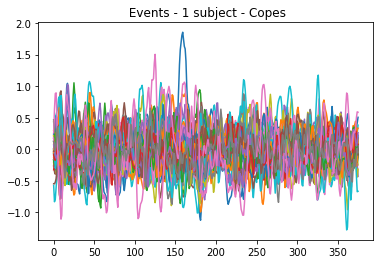

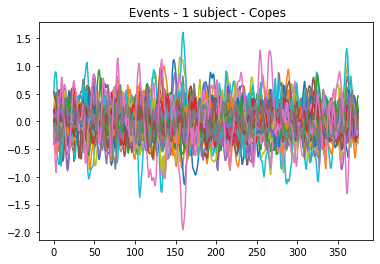

In [124]:
for i in range(2):
    cope = copes_both_contrasts[i]
    plt.figure()
    plt.title(' Events - 1 subject - Copes')
    for j in range(38):
        plt.plot(cope[j])

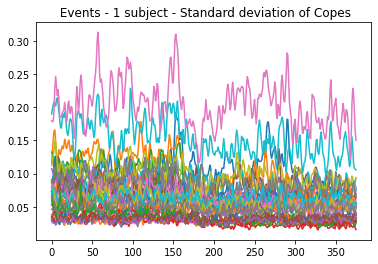

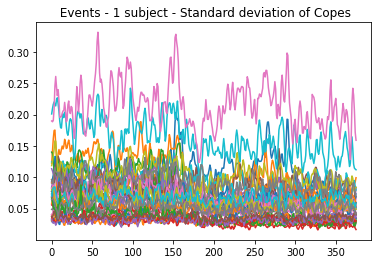

In [125]:
for i in range(2):
    std_cope = stdcopes_array_both_contrasts[i]
    plt.figure()
    plt.title(' Events - 1 subject - Standard deviation of Copes')
    for j in range(38):
        plt.plot(std_cope[j])

## **For the entire group of 110 subjects**

In [ ]:
subject_data = all_epochs_paths

# Initialize empty list to store GLMEpochsResult objects for each subject
subject_results = []

# Loop over subjects
for subject_path in subject_data:
    # Run GLM analysis for the current subject (using the same design_config as defined above)
    result_for_subject = osl.glm.glm_epochs(design_config, mne.read_epochs(subject_path))

    # Append the result for the current subject to the list
    subject_results.append(result_for_subject)

# Convert the list of GLMEpochsResult objects to a numpy array
subject_results_array = np.array(subject_results)

In [127]:
# Adapted from: https://github.com/OHBA-analysis/osl

class GroupGLMEpochs(osl.glm.GroupGLMBaseResult):
    """A class for group level GLM-Spectra fitted across mmultiple first-level
    GLM-Spectra computed from MNE-Python Raw objects"""

    def __init__(self, model, design, info, fl_contrast_names=None, data=None, tmin=0, times=None):

        self.tmin = tmin
        self.times = times
        super().__init__(model, design, info, fl_contrast_names=fl_contrast_names, data=data)

def group_glm_epochs(inspectra, design_config=None, datainfo=None, metric='copes', baseline=None):
    """Compute a group GLM-Epochs from a set of first-level GLM-Epochs.

    Parameters
    ----------
    inspectra : list, tuple
        A list containing either the filepaths of a set of saved GLM-Epochs
        objects, or the GLM-Epochs objects themselves.
    design_config : glmtools.design.DesignConfig
         The design specification for the group level model (Default value = None)
    datainfo : dict
         Dictionary of data values to use as covariates. The length of each
         covariate must match the number of input GLM-Epochs (Default value =
         None)
    metric : {'copes', or 'tsats'}
         Which metric to plot (Default value = 'copes')

    Returns
    -------
    GroupGLMEpochs

    """
    datainfo = {} if datainfo is None else datainfo

    fl_data = []
    ## Need to sanity check that info and configs match before concatenating
    for ii in range(len(inspectra)):
        if isinstance(inspectra[ii], str):
            glmep = read_glm_epochs(inspectra[ii])
        else:
            glmep = inspectra[ii]

        fl_data.append(getattr(glmep.model, metric)[np.newaxis, ...])
        fl_contrast_names = glmep.design.contrast_names

    fl_data = np.concatenate(fl_data, axis=0)
    group_data = glm.data.TrialGLMData(data=fl_data, **datainfo)

    design = design_config.design_from_datainfo(group_data.info)
    model = glm.fit.OLSModel(design, group_data)
    
    return model.copes, model.varcopes

In [128]:
# Create a GroupGLMEpochs object using the group_glm_epochs function
group_copes, group_varcopes = group_glm_epochs(inspectra=subject_results_array, design_config=design_config)

In [129]:
print(np.shape(group_copes))

(2, 2, 38, 376)


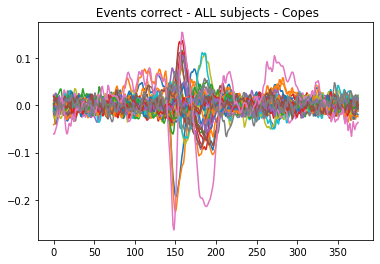

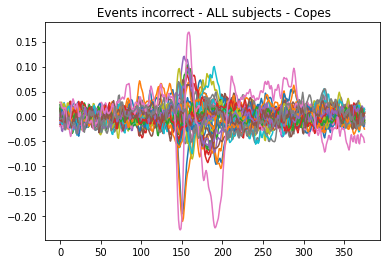

In [130]:
event_type = ['correct', 'incorrect']
for i in range(2):
    cope = group_copes[1][i]
    plt.figure()
    plt.title(' Events ' + event_type[i] + ' - ALL subjects - Copes')
    for j in range(38):
        plt.plot(cope[j])

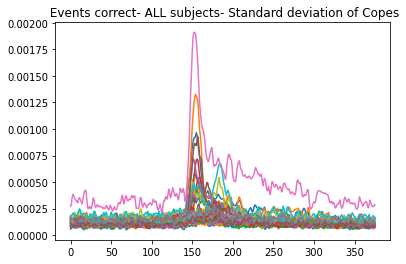

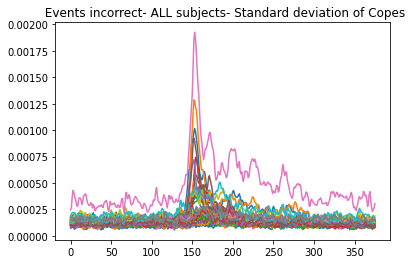

In [131]:
event_type = ['correct', 'incorrect']
for i in range(2):
    varcope = group_varcopes[1][i]
    plt.figure()
    plt.title(' Events ' + event_type[i] + '- ALL subjects- Standard deviation of Copes')
    for j in range(38):
        plt.plot(varcope[j])

## Summarising plot to visualize peaks - Group level

In [132]:
# Define [-500,1000] ms epoch window
fs = 250
t_start = 0.5
t_end = 1
times = np.arange(-t_start,t_end+1/fs,1/fs)

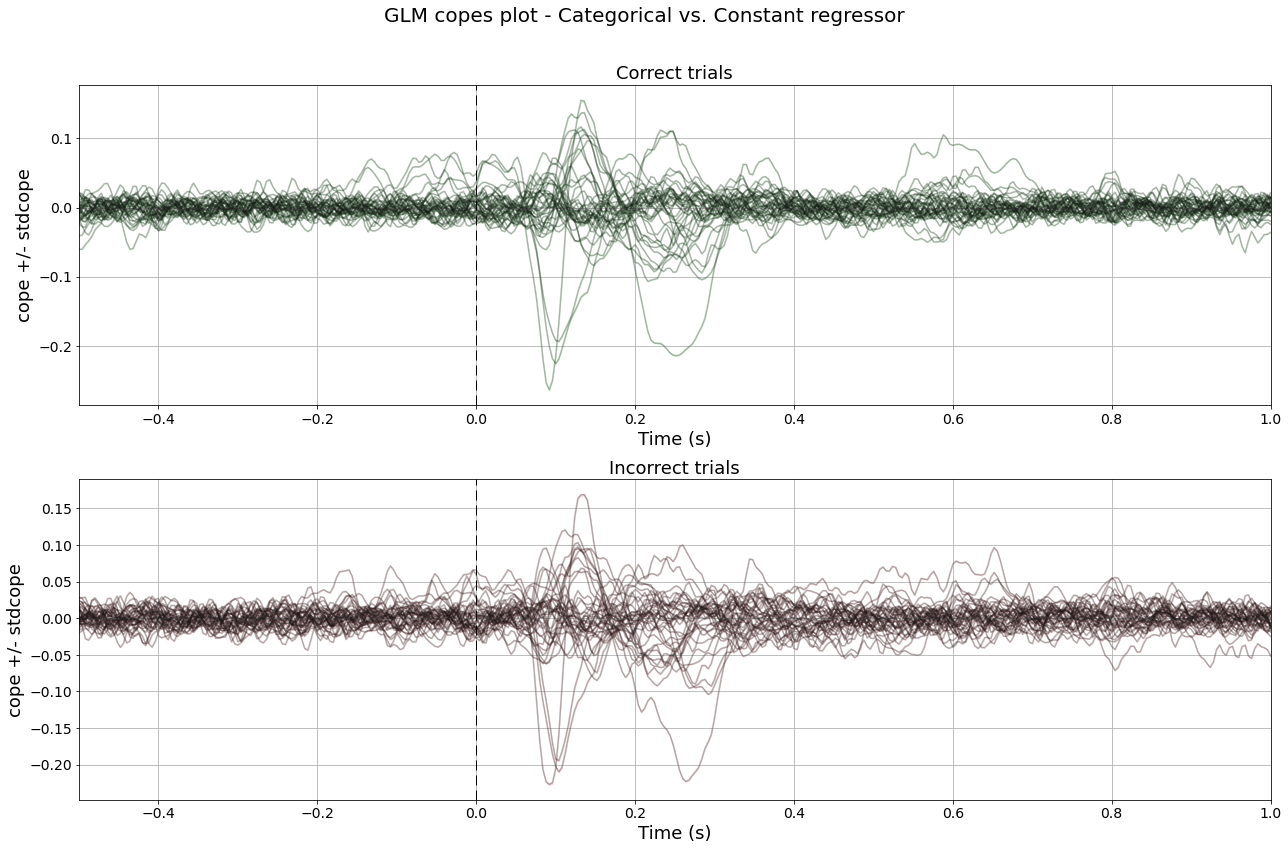

In [144]:
import numpy as np
import matplotlib.pyplot as plt

nroi = 38
groupCope = group_copes[1]
groupStdCope = group_varcopes[1]
gconName = ['Correct/Incorrect Stimuli']
flconName = ['Correct trials','Incorrect trials']

shadingColor = np.array([[0, 0.7, 0], [0.7, 0, 0]])
lineColor = np.array([[0.1, 0.1, 0.1, 0.3], [0.1, 0.1, 0.1, 0.3]])

for gconCounter in range(1): 
    fig, subplotHandle = plt.subplots(2, 1, figsize=(18, 12))
    #fig.suptitle(f'butterfly plot {nroi} parcels, {gconName[gconCounter]}', fontsize=20, color='k')
    fig.suptitle('GLM copes plot - Categorical vs. Constant regressor', fontsize=20, color='k')

    for flconCounter in range(len(flconName)):

        for roiCounter in range(nroi):
            plotData = groupCope[flconCounter,roiCounter,:]
            plotError = groupStdCope[flconCounter,roiCounter, :]

            subplotHandle[flconCounter].fill_between(
                times,
                plotData - plotError,
                plotData + plotError,
                color=shadingColor[flconCounter],
                alpha=0.1,
                linestyle='None'
            )
            subplotHandle[flconCounter].plot(times, plotData, linewidth=1.5, color=lineColor[flconCounter, :])

        subplotHandle[flconCounter].set_xlim([-0.5, 1])
       
        subplotHandle[flconCounter].grid(True)
        subplotHandle[flconCounter].set_xlabel('Time (s)', fontsize=18)
        subplotHandle[flconCounter].set_title(flconName[flconCounter], fontsize=18)

    subplotHandle[0].set_ylabel('cope +/- stdcope', fontsize=18)
    subplotHandle[1].set_ylabel('cope +/- stdcope', fontsize=18)
    
    # Set fontsize for both x and y axes labels
    for ax in subplotHandle:
        ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Add vertical dashed line at x = 0
    for ax in subplotHandle:
        ax.axvline(x=0, color='k', linestyle='--', linewidth=1, dashes=(10, 5))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])

### **Use GLM copes plot to determine which parcels have visibile waveforms --> Used to determine intervals for Amplitude/Latency analysis in Part 3**

In [38]:
# Only those parcels showed task-evoked peaks 
idx_relevant_parcels = [0, 1, 2, 3, 10, 11, 12, 13, 14, 15, 18, 19, 24, 25, 26, 27, 36, 37]

parcel_names_relevant = []
for idx in idx_relevant_parcels:
    parcel_names_relevant.append('parcel_' + str(idx))

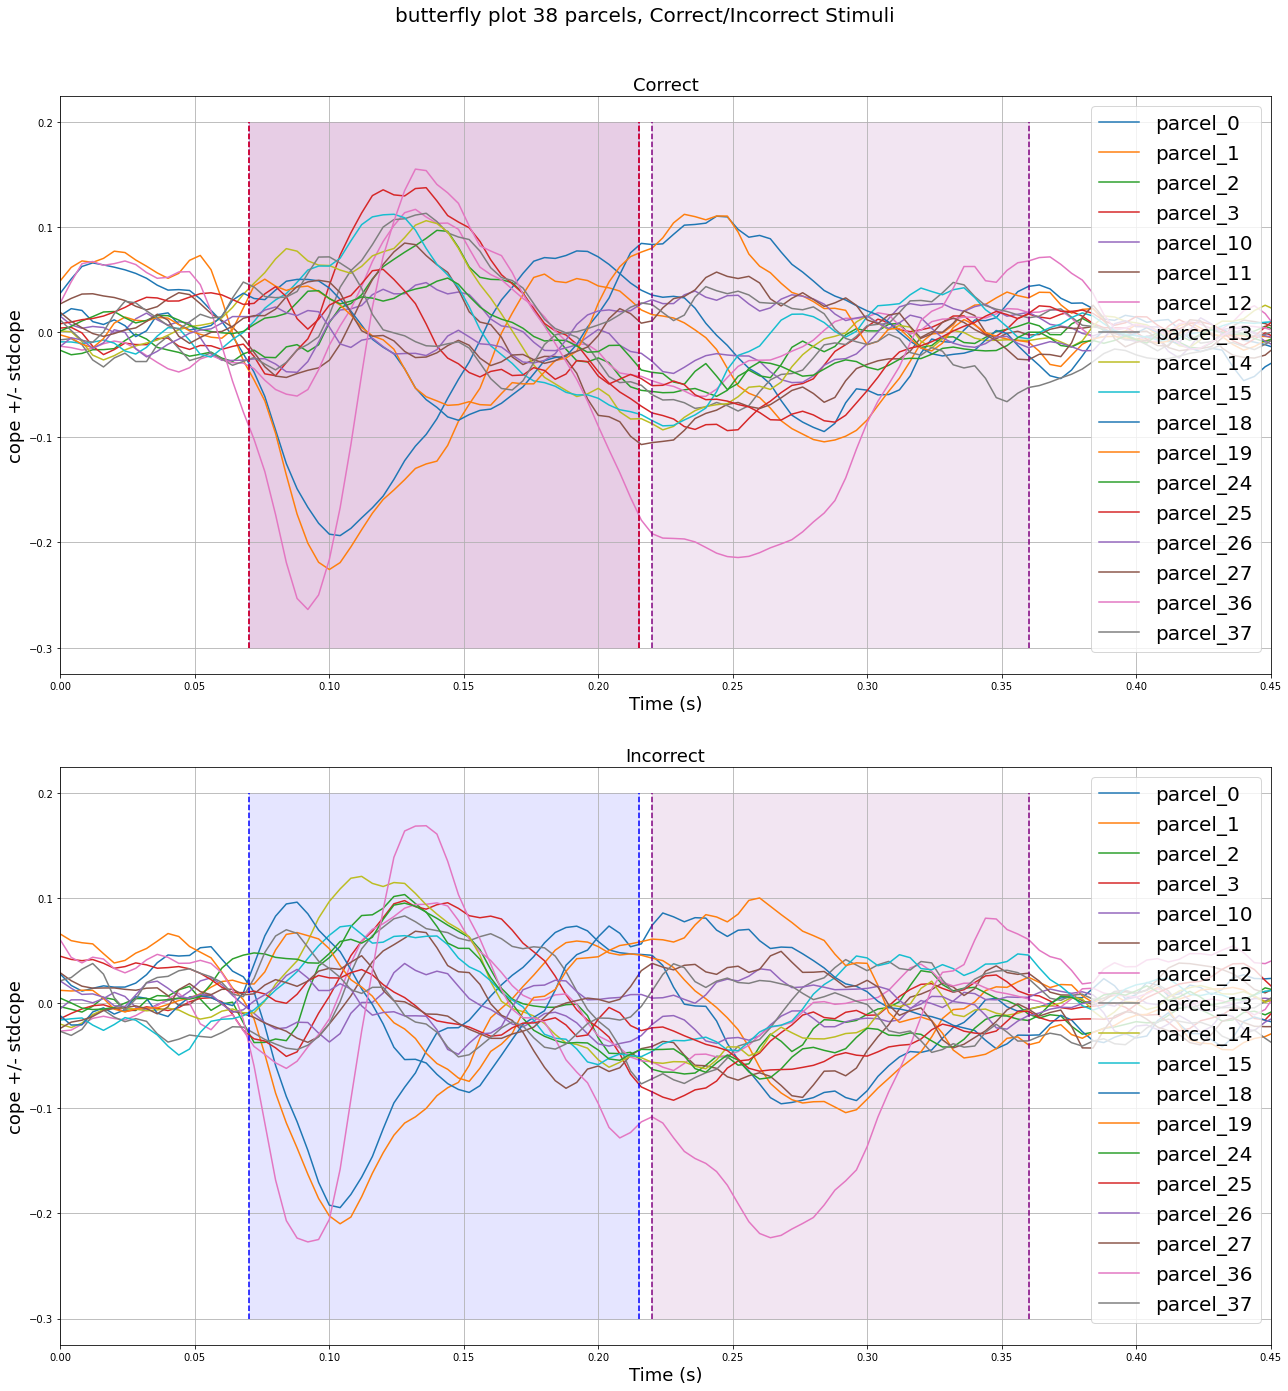

In [41]:
nroi = 38
groupCope = group_copes[1]
groupStdCope = group_varcopes[1]
gconName = ['Correct/Incorrect Stimuli']
flconName = ['Correct','Incorrect']

# Assuming you have defined nroi, groupCope, groupStdCope, gconName, flconName, times, plotdir, and plotGroupName before this code block

#shadingColor = np.array([[0, 0.7, 0], [0.7, 0, 0]])
#lineColor = np.array([[0.1, 0.1, 0.1, 0.3], [0.1, 0.1, 0.1, 0.3]])

for gconCounter in range(1): 
    fig, subplotHandle = plt.subplots(2, 1, figsize=(18, 20))
    fig.suptitle(f'butterfly plot {nroi} parcels, {gconName[gconCounter]}', fontsize=20, color='k')

    for flconCounter in range(len(flconName)):

        for roiCounter in idx_relevant_parcels:
            plotData = groupCope[flconCounter,roiCounter,:]
            plotError = groupStdCope[flconCounter,roiCounter, :]

            #subplotHandle[flconCounter].fill_between(
                #times,
                #plotData - plotError,
                #plotData + plotError,
                #color=shadingColor[flconCounter],
                #alpha=0.9,
                #linestyle='None'
            #)
            subplotHandle[flconCounter].plot(times, plotData, linewidth=1.5)

        subplotHandle[flconCounter].set_xlim([0, 0.45])
       
        subplotHandle[flconCounter].grid(True)
        subplotHandle[flconCounter].set_xlabel('Time (s)', fontsize=18)
        subplotHandle[flconCounter].set_title(flconName[flconCounter], fontsize=18)

    subplotHandle[0].set_ylabel('cope +/- stdcope', fontsize=18)
    subplotHandle[1].set_ylabel('cope +/- stdcope', fontsize=18)
    subplotHandle[0].legend(parcel_names_relevant,fontsize=20)
    subplotHandle[1].legend(parcel_names_relevant,fontsize=20)
    
    ###### Add lines representing the interval boundaries
    
    #########################################################################
    
    ############### CORRECT #####################
    
    ib = 0.03 # increase bound extra 30 ms in each direction
    
    # 1. Positive peak between 70 and 215 ms
    subplotHandle[0].plot([0.1-ib,0.1-ib],[-0.3,0.2],c='blue', linestyle='dashed')
    subplotHandle[0].plot([0.185+ib,0.185+ib],[-0.3,0.2],c='blue', linestyle='dashed')
    
    subplotHandle[0].fill_between(
        [0.1-ib,0.185+ib],
        -0.3,
        0.2,
        color='blue',
        alpha=0.1,
        #linestyle='None'
    )
    
    # 2. Negative peak between 70 and 215 ms
    subplotHandle[0].plot([0.1-ib,0.1-ib],[-0.3,0.2],c='red', linestyle='dashed')
    subplotHandle[0].plot([0.185+ib,0.185+ib],[-0.3,0.2],c='red', linestyle='dashed')
    
    subplotHandle[0].fill_between(
        [0.1-ib,0.185+ib],
        -0.3,
        0.2,
        color='red',
        alpha=0.1,
        #linestyle='None'
    )
    
    # 3. Positive peak between 220 and 360 ms
    subplotHandle[0].plot([0.25-ib,0.25-ib],[-0.3,0.2],c='purple', linestyle='dashed')
    subplotHandle[0].plot([0.33+ib,0.33+ib],[-0.3,0.2],c='purple', linestyle='dashed')
    
    subplotHandle[0].fill_between(
        [0.25-ib,0.33+ib],
        -0.3,
        0.2,
        color='purple',
        alpha=0.1,
        #linestyle='None'
    )
    
    # And a 4th one for the negative
    
    ######### INCORRECT #############
    
    # 1. Positive peak between 70 and 215 ms
    subplotHandle[1].plot([0.1-ib,0.1-ib],[-0.3,0.2],c='blue', linestyle='dashed')
    subplotHandle[1].plot([0.185+ib,0.185+ib],[-0.3,0.2],c='blue', linestyle='dashed')
    
    subplotHandle[1].fill_between(
        [0.1-ib,0.185+ib],
        -0.3,
        0.2,
        color='blue',
        alpha=0.1,
        #linestyle='None'
    )
    
    # 2. Same Negative peak
    
    # 3. Positive peak between 220 and 360 ms
    subplotHandle[1].plot([0.25-ib,0.25-ib],[-0.3,0.2],c='purple', linestyle='dashed')
    subplotHandle[1].plot([0.33+ib,0.33+ib],[-0.3,0.2],c='purple', linestyle='dashed')
    
    subplotHandle[1].fill_between(
        [0.25-ib,0.33+ib],
        -0.3,
        0.2,
        color='purple',
        alpha=0.1,
        #linestyle='None'
    )
    
    # And a 4th one for the negative
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])

## **PCA on copes**

(38, 376)


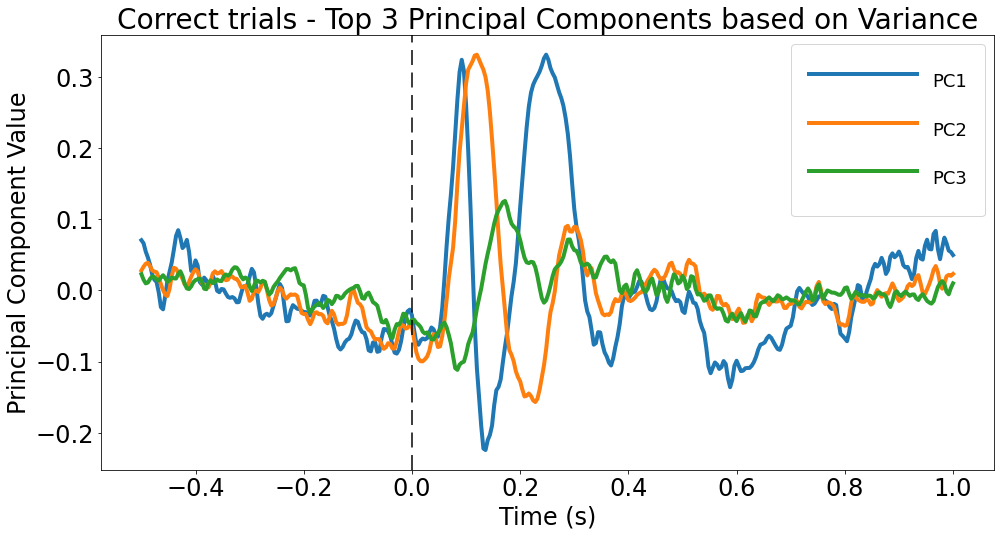

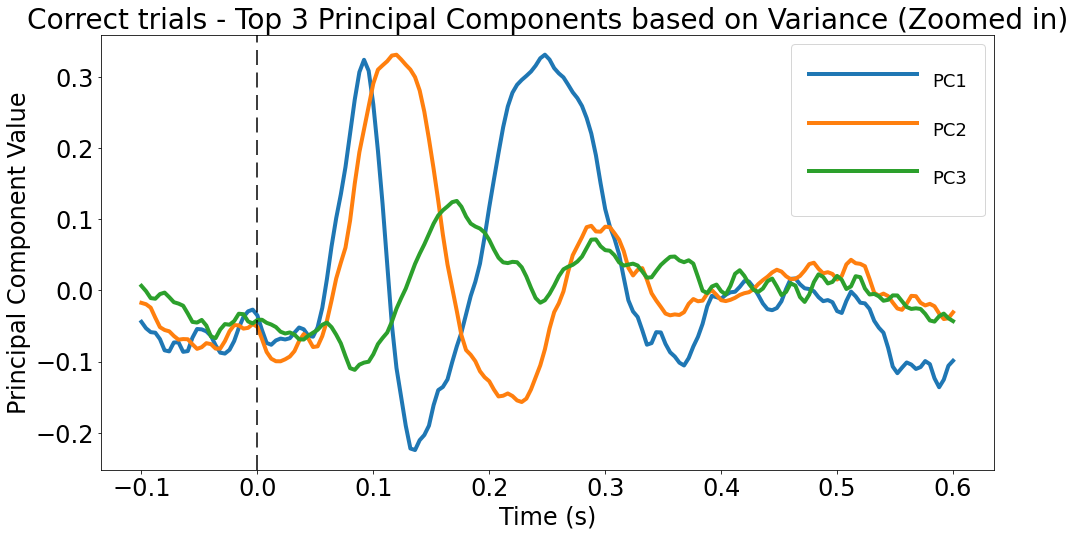

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

nroi = 38
groupCope = group_copes[1]
groupStdCope = group_varcopes[1]
gconName = ['Correct/Incorrect Stimuli']
flconName = ['Correct','Incorrect']

copes_correct = [groupCope[0,chan,:] for chan in range(nroi)]
copes_incorrect = [groupCope[1,chan,:] for chan in range(nroi)]

print(np.shape(copes_correct))

# Initialize PCA with the desired number of components
num_components = 38
pca = PCA(n_components=num_components)

data_reshaped = np.transpose(copes_correct)

# Fit the PCA model to the data
pca.fit(data_reshaped)

# Select the top 3 components based on variance
selected_components = np.argsort(pca.explained_variance_ratio_)[::-1][:3]

# Transform the data to the reduced dimensional space using all components
data_pca_all = pca.transform(data_reshaped)

## Plot the top 3 components
plt.figure(figsize=(16,8))
for i in selected_components:
    plt.plot(times,data_pca_all[:, i], linewidth=4, label=f'PC{i+1}')
plt.axvline(x=0, color='k', linestyle='--', dashes=(10, 5))

plt.xlabel('Time (s)',fontsize=24)
plt.ylabel('Principal Component Value',fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(handlelength=6, handleheight=3, borderpad=1,fontsize=18)
plt.title('Correct trials - Top 3 Principal Components based on Variance',fontsize=28)
plt.show()

## Exact same plot but zoomed in between [-100,600] ms
plt.figure(figsize=(16,8))
for i in selected_components:
    plt.plot(times[100:275+1],data_pca_all[100:275+1, i], linewidth=4, label=f'PC{i+1}')

plt.xlabel('Time (s)',fontsize=24)
plt.ylabel('Principal Component Value',fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(handlelength=6, handleheight=3, borderpad=1,fontsize=18)
plt.title('Correct trials - Top 3 Principal Components based on Variance (Zoomed in)',fontsize=28)
plt.axvline(x=0, color='k', linestyle='--', dashes=(10, 5))
plt.show()

# **Part 2: ERF analysis**

In [ ]:
## Get all the subject averages (parameter avg = True)!

epochs_AVG = []
for i in range(len(all_parceled)):
    epochs_AVG.append(get_epochs_per_subject(all_parceled, nr_subject=i, avg=True, fieldtrip_converted=False, df_events_all=all_dfs_events))

#### Extract parcel names for the used parcellation file

In [12]:
## Parcel names extract

# Open the .txt file for reading
file_path = "/home/olivierb/Downloads/Parcels_38_names.txt"
with open(file_path, 'r') as file:
    lines = file.readlines()

# Strip any leading/trailing whitespace and create a list of strings
parcel_names = [line.strip() for line in lines]

# Print the list of strings
print(parcel_names)

## Parcel indices (how the channel names are stored in the Python parceled .fif files)
parcel_idx= []
for i in range(len(parcel_names)):        # 38 parcels
    parcel_idx.append('parcel_' + str(i))
print(parcel_idx)

['L Cuneus', 'R Cuneus', 'L Inf Occ', 'R Inf Occ', 'L Supramarginal', 'R Supramarginal', 'L Sup Temp', 'R Sup Temp', 'L Lat SMC', 'R Lat SMC', 'L Sup Parietal', 'R Sup Parietal', 'L Middle Occ', 'R Middle Occ', 'L Sup Occ', 'R Sup Occ', 'L Ant Temp', 'R Ant Temp', 'L Medial SMC', 'R Medial SMC', 'L Angular', 'R Angular', 'L VL PFC', 'R VL PFC', 'L Occ pole', 'R Occ pole', 'L Sup PFC', 'R Sup PFC', 'L Sup Dorsal PFC', 'R Sup Dorsal PFC', 'L Orbitofrontal', 'R Orbitofrontal', 'L Post Temp', 'R Post Temp', 'L Inf Dorsal PFC', 'R Inf Dorsal PFC', 'Medial PFC', 'Posterior Cingulate Cortex']
['parcel_0', 'parcel_1', 'parcel_2', 'parcel_3', 'parcel_4', 'parcel_5', 'parcel_6', 'parcel_7', 'parcel_8', 'parcel_9', 'parcel_10', 'parcel_11', 'parcel_12', 'parcel_13', 'parcel_14', 'parcel_15', 'parcel_16', 'parcel_17', 'parcel_18', 'parcel_19', 'parcel_20', 'parcel_21', 'parcel_22', 'parcel_23', 'parcel_24', 'parcel_25', 'parcel_26', 'parcel_27', 'parcel_28', 'parcel_29', 'parcel_30', 'parcel_31', 

## **1. AVG per subject - parcel_0**

#### This was used to see if data from any subject looked really strange

In [ ]:
# All individual subject averages ONLY for parcel_0
check_all_CORR = [subject[0].get_data()[0] for subject in epochs_AVG]
check_all_INCORR = [subject[1].get_data()[0] for subject in epochs_AVG]

fs = 250
t_start = 0.5
t_end = 1
t = np.arange(-t_start,t_end+1/fs,1/fs)

for i in range(len(epochs_AVG)):
    plt.figure(figsize=(10,6))
    plt.plot(t, check_all_CORR[i],label='Correct')   
    plt.plot(t, check_all_INCORR[i],label='Incorrect')
    plt.title(f'Grand average - subject {wanted_sub_IDs[i]} - {parcel_idx[0]} - {parcel_names[0]}') 
    plt.xlabel('Time (s)')
    plt.ylabel('Magnetic field contribution')
    plt.legend()
    plt.show()

## **2. Grand averages: 38x2 (38 parcels, 2 stimuli types) divided into Healthy Controls/PwMS**

### 2.1 First Look at the **AVG across all 38 parcels, split only into **eventtypes****

Identifying common channels ...
Identifying common channels ...


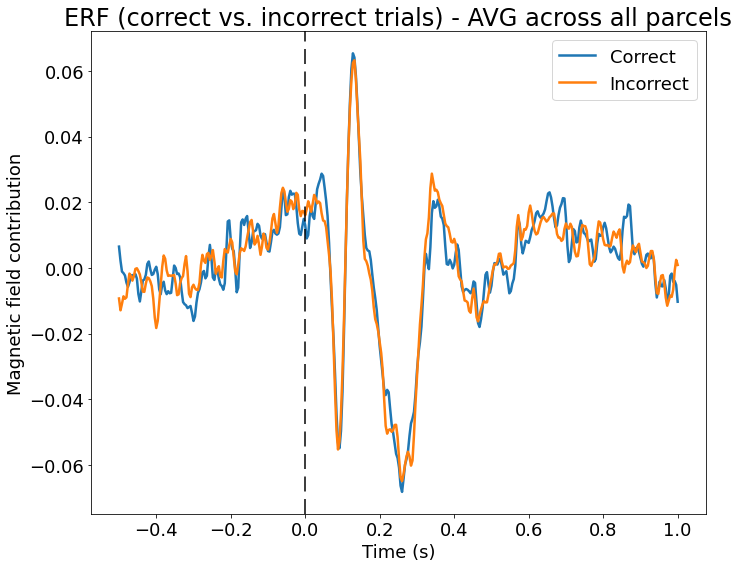

In [159]:
epochs_AVG_CORR = [subject[0] for subject in epochs_AVG]
epochs_AVG_INCORR = [subject[1] for subject in epochs_AVG]

AVG_CORR = np.mean(mne.grand_average(epochs_AVG_CORR).get_data(),axis=0)
AVG_INCORR = np.mean(mne.grand_average(epochs_AVG_INCORR).get_data(),axis=0)

import matplotlib.pyplot as plt
%matplotlib inline

fs = 250
t_start = 0.5
t_end = 1
t = np.arange(-t_start,t_end+1/fs,1/fs)

plt.figure(figsize=(10,8))
        
# Plot "control" vs. "ms" data in the current row and column
plt.plot(t, AVG_CORR, label='Correct', linewidth=2.5)
plt.plot(t, AVG_INCORR, label='Incorrect', linewidth=2.5)
plt.title(f'ERF (correct vs. incorrect trials) - AVG across all parcels', fontsize=24)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Magnetic field contribution', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(handlelength=2, handleheight=1, borderpad=0.4,fontsize=18)
plt.axvline(x=0, color='k', linestyle='--', dashes=(10, 5))

# Add space between subplots to make them more readable
plt.tight_layout()

# Show the plot
plt.show()

### 2.2.1 Then look at **AVG across all 38 parcels**, but also split into **groups & eventtypes**

In [13]:
## First we split the 110 subjects into 2 groups based on the 'subjectinfo.mat'

# Need subject_IDs_group_analysis 

# Function to convert the patientinfo file from .mat format to a Pandas DataFrame
def patientinfo_to_df(patientinfo_mat_path):
    
    array = loadmat(patientinfo_mat_path)['subjectinfo'][0]
    
    # Only the relevant columns are kept
    indices_relevant_cols = [0,3,4,5,6,7,16,19,21,26]
    relevant_col_names = ['code', 'disdur', 'type', 'age', 'edu', 'SDMT', 'gender_isfemale', 'isms', 'EDSS', 'benzos']
    
    # for each of the relevant columns: extract the raw column
    extracted_out = []
    for column in range(len(indices_relevant_cols)):
        extracted_col = [array[patient][indices_relevant_cols[column]] for patient in range(len(array))]
        extracted_out.append(extracted_col)
    
    # For each column: Recursively unpack the values using unpack_nested()
    df_out = pd.DataFrame()
    for col in range(len(indices_relevant_cols)):
        df_out[relevant_col_names[col]] = extracted_out[col]
    
    # Recursively unpack value from nested arrays --> Needed because every column has a different amount of nested arrays used to story its elements
    def unpack_nested(val):
        if isinstance(val, np.ndarray):
            return unpack_nested(val[0])
        else:
            return val
                    
    df_out = df_out.map(unpack_nested)
    
    return df_out

# Function to easily seperate data into 2 groups: Healthy controls and PwMS
def seperate_into_groups_ERF(data, control_idx, ms_idx):
    control_data = [data[i] for i in control_idx]
    ms_data = [data[i] for i in ms_idx]
    return control_data, ms_data

In [ ]:
df_patientinfo = patientinfo_to_df("/home/olivierb/Downloads/subjectinfo.mat")
display(df_patientinfo)

# Get only 110 subjects for which we have both parceled MEG data & eventtables
filtered_df = df_patientinfo[df_patientinfo['code'].isin(subject_IDs_group_analysis)].reset_index(drop=True)

# Get all row indices with isms = 0 ==> healthy controls
df_control_idx = filtered_df.index[filtered_df['isms'] == 0].tolist()
print(df_control_idx)
print(len(df_control_idx))

# Get all row indices with isms = 1 ==> MS patients
df_ms_idx = filtered_df.index[filtered_df['isms'] == 1].tolist()
#print(df_ms_idx)
print(len(df_ms_idx))
print(df_ms_idx)

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


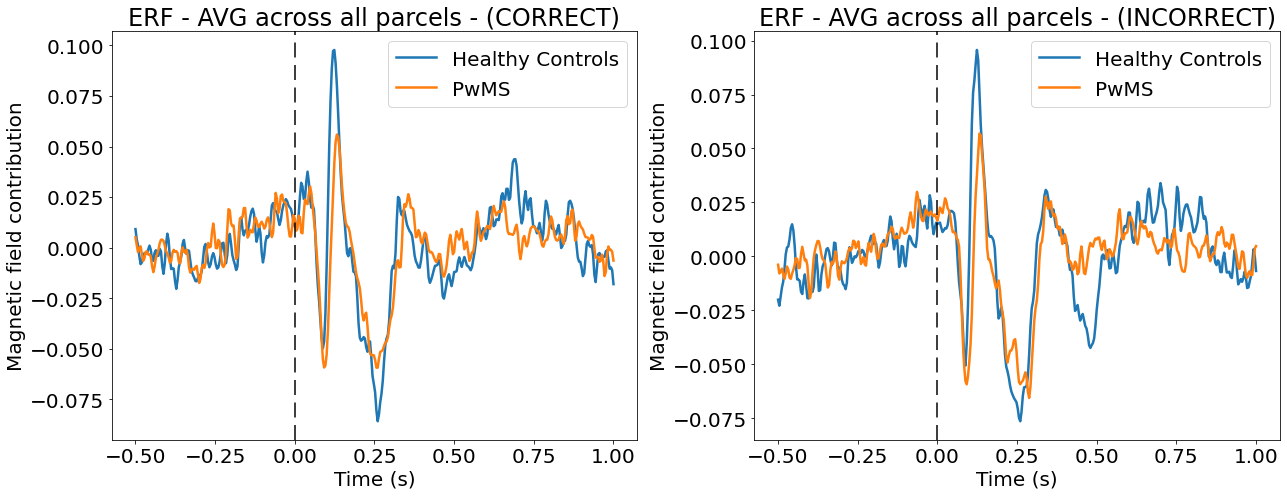

In [164]:
epochs_AVG_CORR = [subject[0] for subject in epochs_AVG]
epochs_AVG_INCORR = [subject[1] for subject in epochs_AVG]

corr_control, corr_ms = seperate_into_groups_ERF(epochs_AVG_CORR, df_control_idx, df_ms_idx)
incorr_control, incorr_ms = seperate_into_groups_ERF(epochs_AVG_INCORR, df_control_idx, df_ms_idx)

%matplotlib inline
GA_CORR_control, GA_INCORR_control = mne.grand_average(corr_control).get_data(), mne.grand_average(incorr_control).get_data()
GA_CORR_ms, GA_INCORR_ms = mne.grand_average(corr_ms).get_data(), mne.grand_average(incorr_ms).get_data()

# Here you take the avg across the 38 parcels -> result is 1D
allsubs_CORR_control, allsubs_INCORR_control = np.mean(GA_CORR_control, axis=0), np.mean(GA_INCORR_control, axis=0)
allsubs_CORR_ms, allsubs_INCORR_ms = np.mean(GA_CORR_ms, axis=0), np.mean(GA_INCORR_ms, axis=0)

fs = 250
t_start = 0.5
t_end = 1
t = np.arange(-t_start,t_end+1/fs,1/fs)

control_plot = [allsubs_CORR_control, allsubs_INCORR_control]
ms_plot = [allsubs_CORR_ms,allsubs_INCORR_ms]

import matplotlib.pyplot as plt

# Assuming you have 38 parcels in your parcel_names
num_rows = 1
num_columns = 2

# Create a figure and axes for subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(9*num_columns, 7*num_rows))  # Adjust figsize as needed

for i in range(num_rows):
    for j in range(num_columns):
        if j < 1:
            data_type = "CORRECT"
        else:
            data_type = "INCORRECT"
            
        # Plot "control" vs. "ms" data in the current row and column
        axs[j].plot(t, control_plot[j], label='Healthy Controls',linewidth=2.5)
        axs[j].plot(t, ms_plot[j], label='PwMS',linewidth=2.5)
        axs[j].set_title(f'ERF - AVG across all parcels - ({data_type})',fontsize=24)
        axs[j].set_xlabel('Time (s)',fontsize=20)
        axs[j].set_ylabel('Magnetic field contribution',fontsize=20)
        axs[j].tick_params(axis='both', which='major', labelsize=20)
        axs[j].legend(handlelength=2, handleheight=1, borderpad=0.4,fontsize=20)
        axs[j].axvline(x=0, color='k', linestyle='--', dashes=(10, 5))

# Add space between subplots to make them more readable
plt.tight_layout()

plt.show()

# Plot "control" vs. "ms" data in the current row and column
#plt.plot(t, AVG_CORR, label='Correct', linewidth=2.5)
#plt.plot(t, AVG_INCORR, label='Incorrect', linewidth=2.5)
#plt.title(f'ERF (correct vs. incorrect trials) - AVG across all parcels', fontsize=24)
#plt.xlabel('Time (s)', fontsize=18)
#plt.ylabel('Magnetic field contribution', fontsize=18)
#plt.xticks(fontsize=18)
#plt.yticks(fontsize=18)
#plt.legend(handlelength=2, handleheight=1, borderpad=0.4,fontsize=18)
#plt.axvline(x=0, color='k', linestyle='--', dashes=(10, 5))

### 2.2.2. Same, but also include a **group comparison (permutation testing with max statistic)** at each timepoint

## **Permutation testing with max statistic (non-parametric approach)**

In [15]:
import glmtools as glm
from scipy import stats

# Adapted from: github.com/OHBA-analysis/osl-dynamics

def _check_glm_data(data, covariates, assignments=None):
    """Check shapes and remove subjects from GLM data which contain nans."""

    # Make sure the number of subjects in data and covariates match
    n_subjects = data.shape[0]
    for k, v in covariates.items():
        if v.shape[0] != n_subjects:
            raise ValueError(
                f"Got covariates['{k}'].shape[0]={v.shape[0]}, "
                + f"but was expecting {n_subjects}."
            )

    # Convert covariates to a numpy array
    if len(covariates) > 0:
        covariates_data = np.array(list(covariates.values())).T

    # Remove subjects with a nan in either array
    remove = []
    for i in range(n_subjects):
        if np.isnan(data[i]).any():
            remove.append(i)
        if len(covariates) > 0:
            if np.isnan(covariates_data[i]).any():
                remove.append(i)
        if assignments is not None:
            if np.isnan(assignments[i]):
                remove.append(i)
    remove = np.unique(remove)
    if len(remove) > 0:
        _logger.warn(f"The following subjects were removed from the GLM: {remove}")

    # Keep subjects without nans
    keep = [i for i in range(n_subjects) if i not in remove]
    data = np.copy(data)[keep]
    covariates_ = {}
    for key in covariates:
        covariates_[key] = covariates[key][keep]
    if assignments is not None:
        assignments = np.copy(assignments)[keep]

    # Check we have some subjects left
    if len(data) == 0:
        raise ValueError("No valid data to calculate the GLM.")

    if assignments is not None:
        return data, covariates_, assignments
    else:
        return data, covariates


In [16]:
# Adapted from: github.com/OHBA-analysis/osl-dynamics

# Function to perform group differences in timeseries data using permutation using with the max statistic
def group_diff_max_stat_perm(
    data, assignments, n_perm, covariates=None, metric="tstats", n_jobs=1
):
    """Statistical significant testing for the difference between two groups.

    This function fits a General Linear Model (GLM) with ordinary least squares
    and performs a row shuffle permutations test with the maximum statistic to
    determine a p-value for differences between two groups.

    Parameters
    ----------
    data : np.ndarray
        Subject-specific quantities to compare. This will be the target data
        for the GLM. Must be shape (n_subjects, features1, features2, ...).
    assignments : np.ndarray
        1D numpy array containing group assignments. A value of 1 indicates
        Group1 and a value of 2 indicates Group2. Note, we test the contrast
        :code:`abs(Group1 - Group2) > 0`.
    n_perm : int
        Number of permutations.
    covariates : dict, optional
        Covariates (extra regressors) to add to the GLM fit. These will be
        z-transformed. Must be of shape (n_subjects,).
    metric : str, optional
        Metric to use to build the null distribution. Can be :code:`'tstats'` or
        :code:`'copes'`.
    n_jobs : int, optional
        Number of processes to run in parallel.

    Returns
    -------
    group_diff : np.ndarray
        Group difference: Group1 - Group2. Shape is (features1, features2, ...).
    pvalues : np.ndarray
        P-values for the features. Shape is (features1, features2, ...).
    """
    if covariates is None:
        covariates = {}
    
    if not isinstance(data, np.ndarray):
        raise ValueError("data must be a numpy array.")

    ndim = data.ndim
    if ndim == 1:
        raise ValueError("data must be 2D or greater.")

    if metric not in ["tstats", "copes"]:
        raise ValueError("metric must be 'tstats' or 'copes'.")

    data, covariates, assignments = _check_glm_data(
        data,
        covariates,
        assignments,
    )

    # Create GLM Dataset
    data = glm.data.TrialGLMData(
        data=data,
        **covariates,
        category_list=assignments,
        dim_labels=["subjects"] + [f"features {i}" for i in range(1, ndim)],
    )

    # Create design matrix
    DC = glm.design.DesignConfig()
    DC.add_regressor(name="Group1", rtype="Categorical", codes=1)
    DC.add_regressor(name="Group2", rtype="Categorical", codes=2)
    for name in covariates:
        DC.add_regressor(
            name=name,
            rtype="Parametric",
            datainfo=name,
            preproc="z",
        )
    DC.add_contrast(name="GroupDiff", values=[1, -1] + [0] * len(covariates))
    design = DC.design_from_datainfo(data.info)

    # Fit model and get t-statistics
    model = glm.fit.OLSModel(design, data)

    # Which dimensions are we pooling over?
    if ndim == 2:
        pooled_dims = 1
    else:
        pooled_dims = tuple(range(1, ndim))

    # Run permutations and get null distribution
    perm = glm.permutations.MaxStatPermutation(
        design,
        data,
        contrast_idx=0,  # selects GroupDiff
        nperms=n_perm,
        metric=metric,
        tail=0,  # two-sided test
        pooled_dims=pooled_dims,
        nprocesses=n_jobs,
    )
    null_dist = perm.nulls

    # Get p-values
    if metric == "tstats":
        print("Using tstats as metric")
        tstats = abs(model.tstats[0])
        percentiles = stats.percentileofscore(null_dist, tstats)
    elif metric == "copes":
        print("Using copes as metric")
        copes = abs(model.copes[0])
        percentiles = stats.percentileofscore(null_dist, copes)
    pvalues = 1 - percentiles / 100

    # Get group differences
    group_diff = model.copes[0]

    return group_diff, pvalues

In [60]:
data_max_stat_perm = []
for sub in range(len(epochs_AVG_CORR)):    # iterate over the subjects
    data_max_stat_perm.append(np.average(epochs_AVG_CORR[sub].get_data(),axis=0))

data_max_stat_perm = np.array(data_max_stat_perm)

In [61]:
assignments = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
               2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1,
               1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1]

epochs_max_stat_perm = [epochs_AVG_CORR, epochs_AVG_INCORR]
group_diff_pvals = []
for amounts in range(len(epochs_max_stat_perm)):
    data = []
    epochs_AVG = epochs_max_stat_perm[amounts]
    for sub in range(len(epochs_AVG)):
        data.append(np.average(epochs_AVG_CORR[sub].get_data(), axis=0))
    data = np.array(data)
    diff, pvals = group_diff_max_stat_perm(data=data, assignments=assignments, n_perm=10000)
    
    group_diff_pvals.append(pvals)
    
    print("Number of significant differences:", np.sum(pvals < 0.05))

Permuting contrast <class 'glmtools.design.Contrast'>(GroupDiff,Differential) with mode=row-shuffle
	Computing 10000 permutations
	Taking max-stat across ['features 1'] dimensions
Using tstats as metric
Number of significant differences: 0
Permuting contrast <class 'glmtools.design.Contrast'>(GroupDiff,Differential) with mode=row-shuffle
	Computing 10000 permutations
	Taking max-stat across ['features 1'] dimensions
Using tstats as metric
Number of significant differences: 0


### 2.3 Same as 2.2, but now **seperately for all 38 parcels**

In [ ]:
## Get all the subject averages!

epochs_AVG = []
for i in range(len(all_parceled)):
    epochs_AVG.append(get_epochs_per_subject(all_parceled, nr_subject=i, avg=True, fieldtrip_converted=False, df_events_all=all_dfs_events))

In [63]:
# Find the min/max amplitude in all Grand Averages --> In order to plot everything on the same scale
all_data = np.concatenate([control_plot[0], control_plot[1], ms_plot[0], ms_plot[1]])
y_min = np.min(all_data)
y_max = np.max(all_data)

print(np.round(y_min), np.round(y_max))

-0.0 0.0


In [ ]:
epochs_AVG_CORR = [subject[0] for subject in epochs_AVG]
epochs_AVG_INCORR = [subject[1] for subject in epochs_AVG]

corr_control, corr_ms = seperate_into_groups_ERF(epochs_AVG_CORR, df_control_idx, df_ms_idx)
incorr_control, incorr_ms = seperate_into_groups_ERF(epochs_AVG_INCORR, df_control_idx, df_ms_idx)

%matplotlib inline
GA_CORR_control, GA_INCORR_control = mne.grand_average(corr_control).get_data(), mne.grand_average(incorr_control).get_data()
GA_CORR_ms, GA_INCORR_ms = mne.grand_average(corr_ms).get_data(), mne.grand_average(incorr_ms).get_data()

fs = 250
t_start = 0.5
t_end = 1
t = np.arange(-t_start,t_end+1/fs,1/fs)

control_plot = [GA_CORR_control, GA_INCORR_control]
ms_plot = [GA_CORR_ms, GA_INCORR_ms]

# Get the y-range (min, max across all signals) that will be used to get plots of the same scaling
all_data = np.concatenate([control_plot[0], control_plot[1], ms_plot[0], ms_plot[1]])
y_min = np.round(np.min(all_data))
y_max = np.round(np.max(all_data))

import matplotlib.pyplot as plt

# Assuming you have 38 parcels in your parcel_names
num_rows = len(parcel_names)
num_columns = 2

# Create a figure and axes for subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(10*num_columns, 6*num_rows))  # Adjust figsize as needed

group_diff_pvals = []

for i in range(num_rows):
    pvals_trial_type = []
    epochs = [epochs_AVG_CORR, epochs_AVG_INCORR]
    for j in range(num_columns):
        if j < 1:
            data_type = "CORRECT"
        else:
            data_type = "INCORRECT"
        
        epochs_stat = epochs[j]
        
        # Plot "control" vs. "ms" data in the current row and column
        axs[i,j].plot(t, control_plot[j][i], label='Control')
        axs[i,j].plot(t, ms_plot[j][i], label='MS')
        axs[i,j].set_title(f'ERF (control vs. MS) - {parcel_idx[i]} - {parcel_names[i]} - ({data_type})')
        axs[i,j].set_xlabel('Time (s)')
        axs[i,j].set_ylabel('Magnetic field contribution')
        axs[i,j].set_ylim([y_min,y_max])
        
        axs[i,j].legend()
        
        data = []
        for sub in range(len(epochs_stat)):
            data.append(epochs_stat[sub].get_data()[i])
        data = np.array(data)
        diff, pvals = group_diff_max_stat_perm(data=data, assignments=assignments, n_perm=10000)
        print("Number of significant differences:", np.sum(pvals < 0.05))
        pvals_trial_type.append(pvals)
        
    group_diff_pvals.append(pvals_trial_type)

    
    print("Number of significant differences:", np.sum(pvals < 0.05))

    # Add space between subplots to make them more readable
plt.tight_layout()

# Show the plot
plt.show()

In [85]:
# Save the p-values

print(np.shape(group_diff_pvals))
np.save('/home/olivierb/Output_Images_Connectivity/ERF/p_values_38_parcels_max_stat/pvals', group_diff_pvals)

(38, 2, 376)


### Plot only the parcels and trial_types which showed stat. sign. activation


In [105]:
# First actually extract the timepoints
idx_diff = []
for parcel in range(len(group_diff_pvals)):
    for trial_type in range(len(group_diff_pvals[parcel])):
        #print("Number of significant differences:", np.sum(group_diff_pvals[parcel][trial_type] < 0.05))
        if np.sum(group_diff_pvals[parcel][trial_type] < 0.05) > 0:
            idx_diff.append([parcel, trial_type])
            print(parcel, trial_type)

idx_diff_times = []        
for combo in idx_diff:
    idx_diff_times.append(t[np.where((group_diff_pvals[combo[0]][combo[1]] < 0.05) == True)[0]])
print(idx_diff_times)

3 0
3 1
14 0
14 1
17 1
31 1
32 0
37 0
37 1
[array([0.096, 0.1  , 0.104, 0.108, 0.112, 0.116, 0.12 ]), array([0.1  , 0.104, 0.108, 0.112, 0.116, 0.12 ]), array([0.336]), array([0.32 , 0.324, 0.328, 0.332, 0.38 , 0.384]), array([-0.196]), array([0.128]), array([-0.244]), array([0.144]), array([0.144, 0.148])]


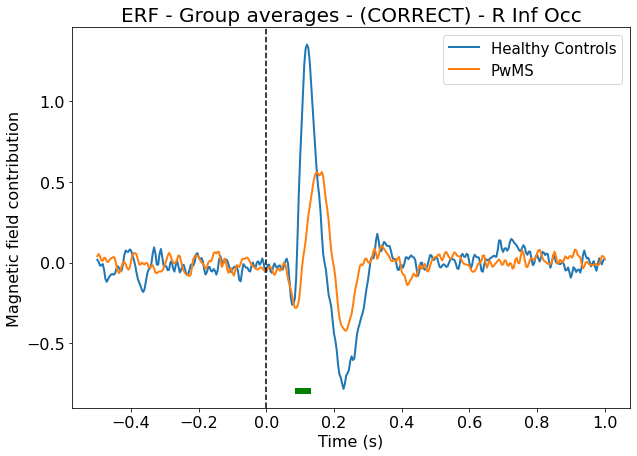

[ 96. 100. 104. 108. 112. 116. 120.]


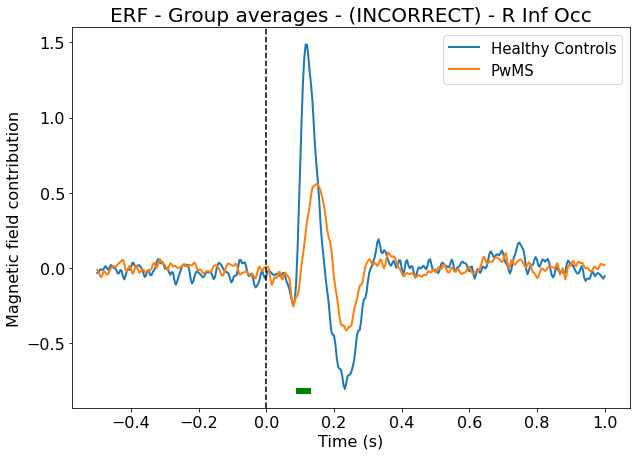

[100. 104. 108. 112. 116. 120.]


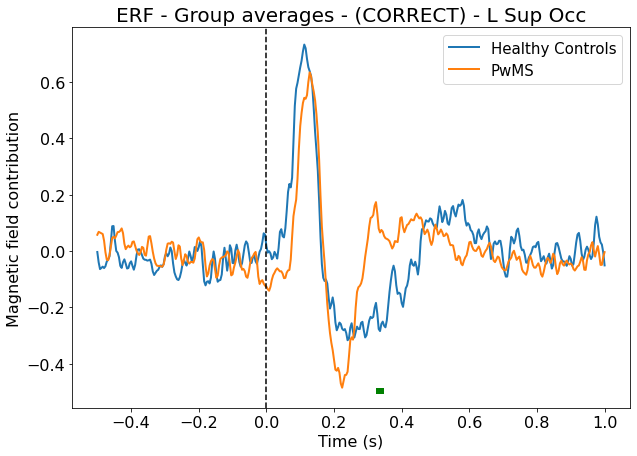

[336.]


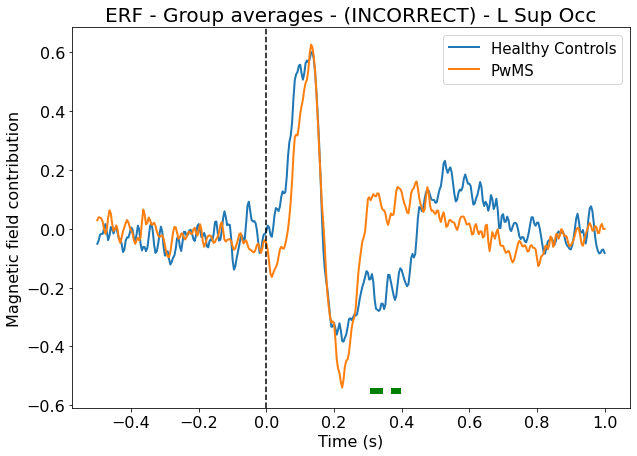

[320. 324. 328. 332. 380. 384.]


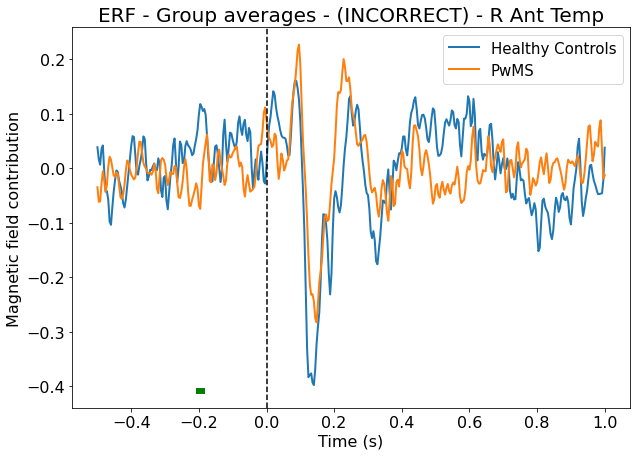

[-196.]


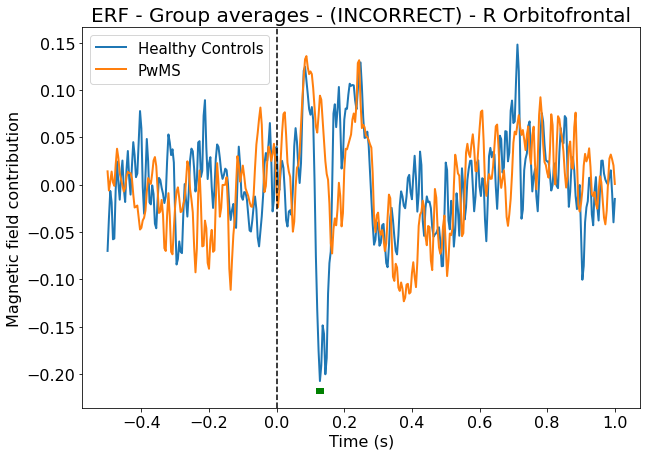

[128.]


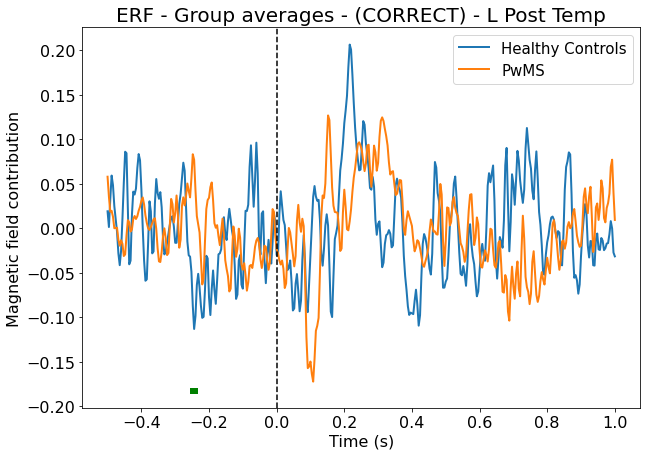

[-244.]


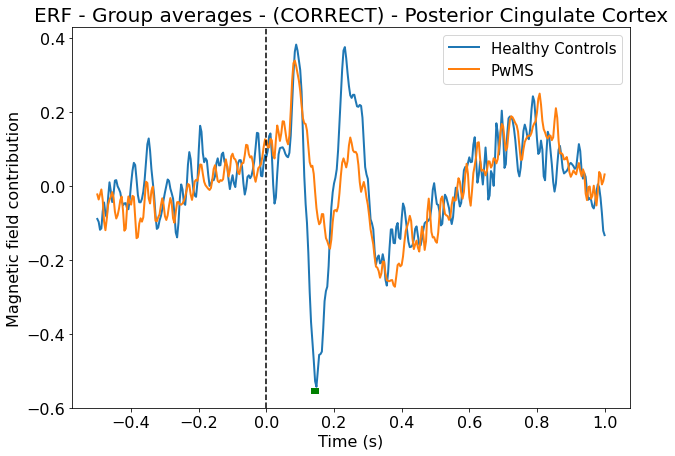

[144.]


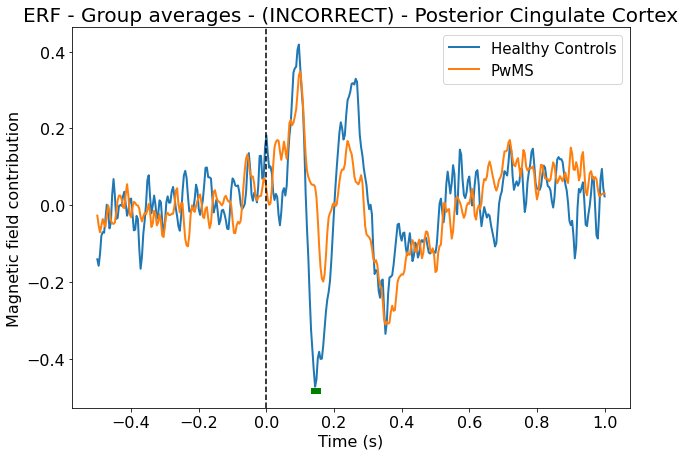

[144. 148.]


In [145]:
# Then make the plots
## For each of the subjects, you keep them seperate + take the average over 38 parcels
control_plot = [GA_CORR_control, GA_INCORR_control]
ms_plot = [GA_CORR_ms, GA_INCORR_ms]

# Loop over each parcel/trial_type combo to plot:
for combo in idx_diff:
    plt.figure(figsize=(10,7))
    plt.plot(t,control_plot[combo[1]][combo[0]], label='Healthy Controls', linewidth='2')   
    plt.plot(t,ms_plot[combo[1]][combo[0]], label='PwMS', linewidth='2')
    
    if combo[1] < 1:
        data_type = "CORRECT"
    else:
        data_type = "INCORRECT"
            
    sig_times = t[np.where((group_diff_pvals[combo[0]][combo[1]] < 0.05) == True)[0]]
            
    # Plot "control" vs. "ms" data in the current row and column
    plt.title(f'ERF - Group averages - ({data_type}) - {parcel_names[combo[0]]}',fontsize=20)
    plt.xlabel('Time (s)',fontsize=16)
    plt.ylabel('Magnetic field contribution',fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.legend(handlelength=2, handleheight=1, borderpad=0.4, fontsize=15)
    plt.axvline(x=0, color='k', linestyle='--')

    draw = min(np.min(control_plot[combo[1]][combo[0]]), np.min(ms_plot[combo[1]][combo[0]]))
    if len(sig_times) > 0:
        dt = t[1] - t[0]
        y = - 0.01 + draw                 # this value needs to be changed
        for st in sig_times:
                plt.plot((st - dt, st + dt), (y, y), linewidth=6, color='g')
        
    plt.show()

# **Part 3: Amplitude/Latency study**

### Create the empty dataframes to store peak amplitudes and corresponding delays w.r.t. stimulus onset

In [72]:
col_names = []
for i in range(38):
    col_names.append('parcel_' + str(i))
# add a last column that keeps track to which subjects the retrieved data belongs to
col_names.append('subject_nr')
col_names.append('trial_type')
col_names.append('peak_type')

amp_df = pd.DataFrame(columns=col_names)
del_df = pd.DataFrame(columns=col_names)

### **Define the time-intervals based on the GLM copes**

In [73]:
# Structure of the inverals needs to be as follows:

# list = [[intervals_correct],[intervals_incorrect]]
# with intervals_correct = [[50,100], [120, 150], [160,180]] for example
# AND it needs to have an associated list_names that contains names for each interval => that will go into the peak_type column name

In [75]:
# Function to convert ms after stimulus -> datasample index
def get_boundaries(interval, time):
    idx_stim = np.where(time == 0)[0][0]
    start = np.abs(time[idx_stim:]*1000 - interval[0]).argmin()   # x1000 to convert from s to ms -> means interval input to the function is given in ms units !!
    end = np.abs(time[idx_stim:]*1000 - interval[1]).argmin()
    return [start+idx_stim, end+idx_stim]                         # the sample numbers which define the boundaries 

In [76]:
# Function to obtain the features for 1 epoch - 1 time interval - 1 polarity type
def get_epoch_features_for_peak(data, interval, interval_name, times):
    # get the index coordinates corresponding to the interval timing
    start, end = get_boundaries(interval, times)
    
    features = []
    
    polarity = interval_name[0] # get the 1st char: 'P' or 'N'
    if polarity =='P':
        features_amp = [np.max(data[parcel][start:end]) for parcel in range(len(data))]    
        features_del = [times[np.argmax(data[parcel][start:end]) + start] for parcel in range(len(data))]   

    if polarity == 'N':
        features_amp = [np.min(data[parcel][start:end]) for parcel in range(len(data))]    
        features_del = [times[np.argmin(data[parcel][start:end]) + start] for parcel in range(len(data))]  

    return [features_amp, features_del]

In [79]:
# Main pipeline to extract all peak amplitudes and corresponding latencies w.r.t. stimulus onset
def extract_amplitudes_and_delays(all_trials, nr_subject, intervals, intervals_names, amplitude_df, delays_df, column_names):
    
    # interval input -> in ms 
    event_type = ['correct', 'incorrect']
    amount_event_types = len(all_trials)     # will be = 1 if the epoch is already averaged per subject
    times = all_trials[0].times
    
    ###########################################
    # Structure:
    # - for 2 trial types (correct/incorrect)
    #      - per epoch
    #             - per peak_type
    #                   - per parcel
    ##########################################
    
    amps = []
    delays = []
    
    for types in range(amount_event_types):
        data = all_trials[types].get_data()    # will get either correct or incorrect trials
        
        amps_types = []
        delays_types = []
        
        ###### INFO #######
        # Not worth it doing the peak-wise analysis when you have N epochs per subject -> not implemented in the code so far
        ###################
        
        ## for all the non-averaged epochs (epochs, parcels, samples)
        if len(np.shape(data)) > 2: 
            for epoch in range(len(data)):
                amps_epoch = []
                delays_epoch = []
                for parcel in range(len(data[epoch])):
                    amps_epoch.append((data[epoch][parcel][np.argmax(np.abs(data[epoch][parcel][start:end])) + start]))                 
                    delays_epoch.append(times[np.argmax(data[epoch][parcel][start:end]) + start]*1000)   # expressed in ms

                # add info to keep track of nr° of subject & trial type
                amps_epoch.append(nr_subject)
                delays_epoch.append(nr_subject)
                amps_epoch.append(event_type[types])
                delays_epoch.append(event_type[types])
            
                amps_types.append(amps_epoch)
                delays_types.append(delays_epoch)
        
        ## for average epochs per subject (parcels, samples)
        elif len(np.shape(data)) == 2:
            amps_avg_epoch = []
            delays_avg_epoch = []
            for peak_type in range(len(intervals[types])):
                amp_peak, del_peak = [], []
                amp_peak, del_peak = get_epoch_features_for_peak(data, intervals[types][peak_type], intervals_names[peak_type], times) # per correct/incorrect and per peak_type
                
                # add info to keep track of nr° of subject & trial type
                amp_peak.append(nr_subject)
                amp_peak.append(event_type[types])
                amp_peak.append(intervals_names[peak_type])
                del_peak.append(nr_subject)
                del_peak.append(event_type[types])
                del_peak.append(intervals_names[peak_type])
                
                amps_avg_epoch.append(amp_peak)
                delays_avg_epoch.append(del_peak)
                
            
            amps_types.append(amps_avg_epoch)
            delays_types.append(delays_avg_epoch)
            
        amps.append(amps_types)
        delays.append(delays_types)
    
    
    amps = np.vstack((amps[0], amps[1]))
    amps = amps.reshape((np.shape(amps)[0] * np.shape(amps)[1], np.shape(amps)[2]))   # reshape step to ensure 2D input (rows x columns)

    delays = np.vstack((delays[0], delays[1]))
    delays = delays.reshape((np.shape(delays)[0] * np.shape(delays)[1], np.shape(delays)[2]))    # reshape step to ensure 2D input (rows x columns)
    
    amp_df = pd.concat([amplitude_df, pd.DataFrame(amps, columns=col_names)], ignore_index=True, axis=0)
    del_df = pd.concat([delays_df, pd.DataFrame(delays, columns=col_names)], ignore_index=True, axis=0)
    print(nr_subject,len(amp_df))
    print('"""""""""""""""""""""""""""""""""""""""""')
    
    return amp_df, del_df

In [80]:
# Create a function to determine the 'group' value inside the dataframe
def assign_group(patient_number):
    if patient_number in df_control_idx:
        return 'control'
    else:
        return 'ms'

### **Apply all previously created functions to run the full pipeline**

In [81]:
## Define column names

col_names = []
for i in range(38):
    col_names.append('parcel_' + str(i))
# add a last column that keeps track to which subjects the retrieved data belongs to
col_names.append('subject_nr')
col_names.append('trial_type')
col_names.append('peak_type')

amp_df = pd.DataFrame(columns=col_names)
del_df = pd.DataFrame(columns=col_names)

## Define example intervals & interval_names

intervals = [[[70,215], [70,215], [220,360], [220,360]],
             [[70, 215], [70, 215], [220, 360], [220, 360]]]
intervals_names = ['P100', 'N100', 'P300', 'N300']    


## Extract AVG epochs + amplitude & latencies
    
for i in range(len(all_parceled)):
    output_test = get_epochs_per_subject(all_parceled, nr_subject=i, avg=True, fieldtrip_converted=False, df_events_all=all_dfs_events)
    
    # dataframes with amplitudes and delays get updated after each subject data has been epoched
    amp_df, del_df = extract_amplitudes_and_delays(output_test, nr_subject=i, intervals=intervals, intervals_names=intervals_names, 
                                                   amplitude_df=amp_df, delays_df=del_df, column_names=col_names)

Opening raw data file /home/olivierb/FULLY_PROCESSED/processed_WITHOUT_orth/parc_0925_raw.fif...
    Range : 26250 ... 325749 =    105.000 ...  1302.996 secs
Ready.
Not setting metadata
61 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 61 events and 376 original time points ...
0 bad epochs dropped
Not setting metadata
67 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 67 events and 376 original time points ...
0 bad epochs dropped
((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ())
((), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (), (),

In [82]:
## Enforce data for amp and del to be of type float (for the parcel columns) & int (for the subject_nr column) 

## Amps
columns_to_enforce_float = amp_df.columns[:38]
dtype_dict = {col: float for col in columns_to_enforce_float}

amp_df = amp_df.astype(dtype_dict)
amp_df['subject_nr'] = amp_df['subject_nr'].astype(int)

## Delays
del_df = del_df.astype(dtype_dict)
del_df['subject_nr'] = del_df['subject_nr'].astype(int)

In [83]:
# Create a function to determine the 'group' value
def assign_group(patient_number):
    if patient_number in df_control_idx:
        return 'control'
    else:
        return 'ms'
    
# Use the apply method to create the 'group' column
amp_df['group'] = amp_df['subject_nr'].apply(assign_group)
del_df['group'] = del_df['subject_nr'].apply(assign_group)


# Print the DataFrame
display(del_df)

parcel_0  parcel_1  parcel_2  parcel_3  parcel_4  parcel_5  parcel_6  \
0       0.204     0.104     0.212     0.136     0.168     0.076     0.172   
1       0.124     0.168     0.148     0.212     0.196     0.192     0.092   
2       0.220     0.240     0.220     0.272     0.308     0.308     0.252   
3       0.288     0.308     0.248     0.228     0.264     0.272     0.280   
4       0.212     0.204     0.200     0.120     0.136     0.136     0.196   
..        ...       ...       ...       ...       ...       ...       ...   
875     0.220     0.272     0.236     0.224     0.224     0.276     0.312   
876     0.104     0.116     0.184     0.112     0.168     0.152     0.068   
877     0.172     0.088     0.128     0.196     0.208     0.188     0.112   
878     0.308     0.316     0.316     0.348     0.296     0.228     0.252   
879     0.280     0.256     0.224     0.244     0.228     0.292     0.300   

     parcel_7  parcel_8  parcel_9  ...  parcel_32  parcel_33  parcel_34  \
0       0.188     0.124     0.188  ...      0.144      0.080      0.148   
1       0.148     0.172     0.092  ...      0.088      0.112      0.120   
2       0.332     0.356     0.280  ...      0.256      0.252      0.292   
3       0.264     0.224     0.308  ...      0.332      0.336      0.220   
4       0.076     0.140     0.192  ...      0.132      0.176      0.192   
..        ...       ...       ...  ...        ...        ...        ...   
875     0.240     0.256     0.236  ...      0.312      0.284      0.328   
876     0.108     0.100     0.140  ...      0.152      0.184      0.164   
877     0.160     0.192     0.084  ...      0.112      0.084      0.096   
878     0.264     0.344     0.276  ...      0.352      0.220      0.228   
879     0.220     0.224     0.308  ...      0.336      0.296      0.312   

     parcel_35  parcel_36  parcel_37  subject_nr  trial_type  peak_type  \
0        0.104      0.136      0.072           0     correct       P100   
1        0.200      0.088      0.128           0     correct       N100   
2        0.276      0.352      0.276           0     correct       P300   
3        0.316      0.304      0.332           0     correct       N300   
4        0.108      0.116      0.168           0   incorrect       P100   
..         ...        ...        ...         ...         ...        ...   
875      0.344      0.232      0.220         109     correct       N300   
876      0.160      0.116      0.096         109   incorrect       P100   
877      0.096      0.212      0.160         109   incorrect       N100   
878      0.224      0.316      0.312         109   incorrect       P300   
879      0.312      0.248      0.220         109   incorrect       N300   

       group  
0         ms  
1         ms  
2         ms  
3         ms  
4         ms  
..       ...  
875  control  
876  control  
877  control  
878  control  
879  control  

[880 rows x 42 columns]

### Code for **permutation testing**

In [84]:
# Code to run permutation testing for group comparisons between 2 groups
def group_comparison(groups, pval_name):
    
    data_HC = groups[0]
    data_MS = groups[1]
    
    p_values_group = np.ones((38,38))
    count = 0
    for i in range(38):
        for j in range(38):
            if i < j and i != j: # avoid unecessary & symmetrical connections
                print(count)
                count+=1
                connection_index = (i, j)
                observed_values_HC = [sub[connection_index] for sub in data_HC]
                observed_values_MS = [sub[connection_index] for sub in data_MS]
                p_values_group[i, j] = permutation_test(observed_values_HC, observed_values_MS)

    np.save('/home/olivierb/Output_Images_Connectivity/p_values/permutation_testing/' + 'group_' + pval_name, p_values_group)

In [85]:
import numpy as np
from scipy.stats import ttest_ind
from itertools import permutations
from joblib import Parallel, delayed
from sklearn.utils import shuffle

# Function specifically for implemention of the the permutation test with t-statistic formula
def permutation_test(observed_group1, observed_group2, num_permutations=1000):
    combined_data = np.concatenate((observed_group1, observed_group2))
    n_group1 = len(observed_group1)

    observed_t_stat, _ = ttest_ind(observed_group1, observed_group2)

    count = 1
    
    for _ in range(num_permutations):
        # Shuffle the combined group data
        shuffled_data = shuffle(combined_data)
        
        # Split the shuffled data into two groups
        permuted_group1 = shuffled_data[:n_group1]
        permuted_group2 = shuffled_data[n_group1:]

        # Calculate the t-statistic for the permuted groups
        t_stat, _ = ttest_ind(permuted_group1, permuted_group2)
        
        if t_stat > observed_t_stat:
            count += 1

    # Calculate p-value
    p_value = count / (num_permutations+1)
    
    return p_value

## Plotting
### **Correct trials**

In [165]:
%%time
# Statistical test used here -> permutation test with t-statistic

idx_P100 = [2, 3, 10, 11, 12, 13, 14, 15, 18, 19, 24, 25, 26, 27, 37]
idx_N100 = [0, 1, 10, 11, 12, 13, 18, 19, 36]
idx_P300 = [18, 19, 26, 27, 37]
idx_N300 = [0, 1, 2, 3, 10, 11, 12, 13, 14, 15, 24, 25, 36] 

# How many tests in total: 42 x 2 = 84 comparisons

parcels_P100 = [parcel_idx[idx] for idx in idx_P100]
parcels_N100 = [parcel_idx[idx] for idx in idx_N100]
parcels_P300 = [parcel_idx[idx] for idx in idx_P300]
parcels_N300 = [parcel_idx[idx] for idx in idx_N300]

df_amp_P100 = amp_df.loc[amp_df['peak_type']=='P100']
df_amp_N100 = amp_df.loc[amp_df['peak_type']=='N100']
df_amp_P300 = amp_df.loc[amp_df['peak_type']=='P300']
df_amp_N300 = amp_df.loc[amp_df['peak_type']=='N300']

df_del_P100 = del_df.loc[del_df['peak_type']=='P100']
df_del_N100 = del_df.loc[del_df['peak_type']=='N100']
df_del_P300 = del_df.loc[del_df['peak_type']=='P300']
df_del_N300 = del_df.loc[del_df['peak_type']=='N300']

data = [[df_amp_P100, df_del_P100], [df_amp_N100, df_del_N100], [df_amp_P300, df_del_P300], [df_amp_N300, df_del_N300]]
to_plot_parcels = [parcels_P100, parcels_N100, parcels_P300, parcels_N300]

event = 'correct'
intervals_names = ['P100', 'N100', 'P300', 'N300']

## Make a Nx2 plot for each parcel, repeat for all parcels within each peak_type
significant_differences_correct = []
all_pvals = []

for peak_type in range(len(data)):
    
    ## Make Nx2 plot
    rows = len(to_plot_parcels[peak_type])
    cols = 2
    data_type = intervals_names[peak_type] 
    parcel_count = 0
    
    for parcel in to_plot_parcels[peak_type]:
        
        # For amp/latency plots
        for i in range(len(data[peak_type])):
            
            ax = axs[parcel_count,i]
            if i < 1:
                types = 'amplitude'
            else:
                types = 'delay'
            
            data_control = data[peak_type][i].loc[(data[peak_type][i]['group'] == 'control') & (data[peak_type][i]['trial_type'] == event)][parcel].tolist()
            data_ms = data[peak_type][i].loc[(data[peak_type][i]['group'] == 'ms') & (data[peak_type][i]['trial_type'] == event)][parcel].tolist()
            
            if types == 'delay':
                data_control = [x * 1000 for x in data_control]
                data_ms = [x * 1000 for x in data_ms]
            
            p_value = permutation_test(data_control, data_ms, num_permutations=10000)
            all_pvals.append(p_value)
            
            if p_value < 0.05:
                
            
                significant_differences_correct.append([data_type, parcel, types, event, p_value])
                print(data_type, parcel, types, event, p_value)
            
            
        parcel_count += 1

P100 parcel_3 amplitude correct 0.0206979302069793
P100 parcel_18 delay correct 0.009499050094990502
P100 parcel_24 amplitude correct 0.0463953604639536
N100 parcel_36 delay correct 0.0207979202079792
P300 parcel_27 delay correct 0.0316968303169683
P300 parcel_37 amplitude correct 0.005099490050994901
N300 parcel_1 amplitude correct 0.03519648035196481
N300 parcel_14 delay correct 0.025697430256974303
CPU times: user 17min 23s, sys: 0 ns, total: 17min 23s
Wall time: 17min 23s


In [233]:
## Save the pvalues just in case
print(np.shape(all_pvals))
print(np.shape(significant_differences_correct))

np.save('/home/olivierb/Output_Images_Connectivity/ERF/p_values_Amplitude_Latency_Correct/pvals_all', all_pvals)
np.save('/home/olivierb/Output_Images_Connectivity/ERF/p_values_Amplitude_Latency_Correct/significant_differences_correct', significant_differences_correct)

(84,)
(8, 5)


### **multiple comparison correction**

In [167]:
from statsmodels.stats.multitest import fdrcorrection
import statsmodels

# Function to correct p-values for multiple comparisons using False Discovery Rate (FDR)
def multiple_comparison_correction(list_of_pvals):

    output = scipy.stats.false_discovery_control(list_of_pvals)
    
    print(len(output[output < 0.05])) # how many connections show stat.significant difference after permutation testing & multiple comparison correction
    print(output[output < 0.05])      # what pvalue do we have there
    print(np.where(output < 0.05)[0]) # get the location indices of this stat.sign. difference connection
    
    return output

In [168]:
multiple_comparison_correction(all_pvals)

0
[]
[]


array([1.        , 1.        , 0.42235776, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.69433057, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.3989601 , 1.        , 0.69433057,
       0.48715128, 1.        , 1.        , 1.        , 0.69433057,
       0.69433057, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.42235776, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.42235776, 0.3989601 , 1.        , 1.        , 1.        ,
       0.42235776, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

### Summarize results using boxplots, **seperate figures for Amplitude/Latency**

In [236]:
significant_differences_correct

[['P100', 'parcel_3', 'amplitude', 'correct', 0.0206979302069793],
 ['P100', 'parcel_18', 'delay', 'correct', 0.009499050094990502],
 ['P100', 'parcel_24', 'amplitude', 'correct', 0.0463953604639536],
 ['N100', 'parcel_36', 'delay', 'correct', 0.0207979202079792],
 ['P300', 'parcel_27', 'delay', 'correct', 0.0316968303169683],
 ['P300', 'parcel_37', 'amplitude', 'correct', 0.005099490050994901],
 ['N300', 'parcel_1', 'amplitude', 'correct', 0.03519648035196481],
 ['N300', 'parcel_14', 'delay', 'correct', 0.025697430256974303]]

In [397]:
# Function to plot overview figures for the Amplitude/Latency analysis using boxplots
def plot_boxplots(data, type_significant_differences, number_plots, intervals_names, types, title, title_event):
    
    # Define xtick locations
    x = [750*(i+1) for i in range(number_plots)]
    
    # info about contents of type_significant_differences
    # peak_type = [0]
    # parcel = [1]
    # type = [2]
    
    # Scaling factor to convert Latency to ms
    sf = 1
    if title=='Latency':
        sf = 1000
    
    data_boxplot = []
    for plot in range(number_plots):
        peak_type = intervals_names.index(type_significant_differences[plot][0])
        parcel = type_significant_differences[plot][1]
        data_boxplot.append(np.array([np.array(data[peak_type][types].loc[(data[peak_type][types]['group'] == 'control') 
                                                                          & (data[peak_type][types]['trial_type'] == event)][parcel].tolist())*sf, 
                                      np.array(data[peak_type][types].loc[(data[peak_type][types]['group'] == 'ms') 
                                                                          & (data[peak_type][types]['trial_type'] == event)][parcel].tolist())*sf]).T)
    
    if number_plots == 1:
        plt.figure(figsize=(6,5))
    else:
        plt.figure(figsize=(2.5*number_plots,6))
    
    boxes = []
    for plot in range(number_plots):
        # Plot boxplots with different colors and labels
        box = plt.boxplot(data_boxplot[plot], 0, '', positions=[x[plot]-125, x[plot]+125], widths=170, patch_artist=True, labels=['Healthy Controls', 'PwMS'])
        boxes.append(box)

    # Find max value between Healthy Controls and PwMS, needed to plot the p_value above at a good height
    max_vals = [[item.get_ydata()[1] for item in box['whiskers']][1] for box in boxes]

    # Find overall min & max value, so that the total y height of the plot can be chosen accordingly
    min_val = np.min([[item.get_ydata()[1] for item in box['whiskers']][0] for box in boxes])
    max_val_overall = np.max(max_vals)

    # Set colors for the boxplots
    colors = [['lightblue', 'lightgreen'] for plots in range(number_plots)]
    #print(colors)
    for i, box in enumerate(boxes):
        for j, patch in enumerate(box['boxes']):
            patch.set_facecolor(colors[i][j])

    # Set median line color to black
    for box in boxes:
        for median in box['medians']:
            median.set(color='black')

    # Create legend based on the colors
    control_box = boxes[0]["boxes"][0]
    ms_box = boxes[0]["boxes"][1]
    plt.legend([control_box, ms_box], ['Healthy Controls', 'PwMS'], fontsize=13)

    plot_pvals = [np.round(float(type_significant_differences[plot][-1]),4) for plot in range(number_plots)]
    
    plt.xlim(x[0]-350, x[-1]+350)
    plt.xticks(x, [type_significant_differences[plot][0] + ' - ' + parcel_names[parcel_idx.index(type_significant_differences[plot][1])] 
                   for plot in range(number_plots)], rotation=25, fontsize=13)
    plt.title(f'Group differences - Peak {title} - {title_event} trials', fontsize=16)
    
    if title=='Amplitude':
        plt.ylabel('Peak Amplitude', fontsize=14)
        plt.ylim([min_val-1,max_val_overall+2])
        for i in range(len(x)):
            plt.text(x[i], max_vals[i]+0.8, f'p = {plot_pvals[i]}', ha='center', fontsize=11)

    if title=='Latency':
        plt.ylabel('Peak Latency (ms)', fontsize=14)
        plt.ylim([min_val-30,max_val_overall+80])
        for i in range(len(x)):
            plt.text(x[i], max_vals[i]+20, f'p = {plot_pvals[i]}', ha='center', fontsize=11)
    
    plt.show()

# Change some input parameters based on plotting either Amplitude or Latency
def plotting_ERF_Amplitude_Latency(data, significant_differences, event, intervals_names):
    
    if event=='correct':
        title_event = 'Correct'
    if event=='incorrect':
        title_event = 'Incorrect'
    
    ## AMPLITUDE
    types = 0         # 'amplitude'
    AMP_indices = [index for index, sublist in enumerate(significant_differences) if sublist[2] == 'amplitude']
    AMP_significant_differences = np.array(significant_differences)[AMP_indices]

    number_plots = len(AMP_indices)
    if number_plots > 0:
        plot_boxplots(data=data, type_significant_differences=AMP_significant_differences, number_plots=number_plots, intervals_names=intervals_names, 
                      types=types, title='Amplitude', title_event=title_event)
        
    ## LATENCY
    types = 1         # 'latency'
    LAT_indices = [index for index, sublist in enumerate(significant_differences) if sublist[2] == 'delay']
    LAT_significant_differences = np.array(significant_differences)[LAT_indices]

    number_plots = len(LAT_indices)
    if number_plots > 0:
        plot_boxplots(data=data, type_significant_differences=LAT_significant_differences, number_plots=number_plots, intervals_names=intervals_names, 
                      types=types, title='Latency', title_event=title_event)

/tmp/ipykernel_3693931/3643328215.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_boxplot.append(np.array([np.array(data[peak_type][types].loc[(data[peak_type][types]['group'] == 'control')


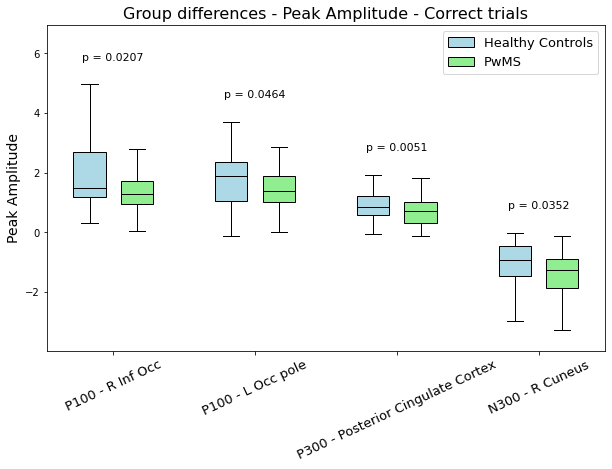

/tmp/ipykernel_3693931/3643328215.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_boxplot.append(np.array([np.array(data[peak_type][types].loc[(data[peak_type][types]['group'] == 'control')


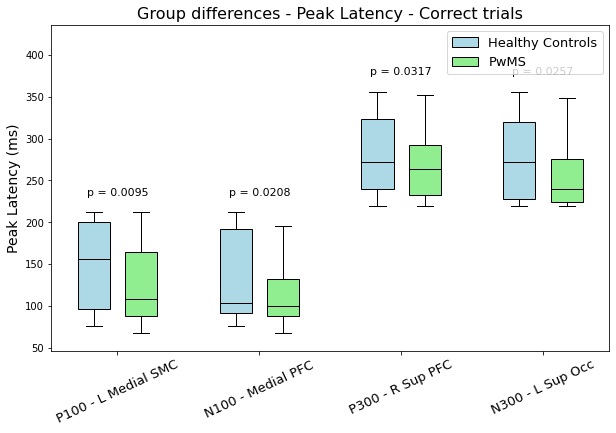

In [398]:
plotting_ERF_Amplitude_Latency(data=data, significant_differences=significant_differences_correct, event='correct', intervals_names=intervals_names)

### **Incorrect trials**

In [234]:
idx_P100 = [2, 3, 10, 11, 12, 13, 14, 15, 18, 19, 24, 25, 26, 27, 37]
idx_N100 = [0, 1, 10, 11, 12, 13, 18, 19, 36]
idx_P300 = [18, 19, 26, 27, 37]
idx_N300 = [0, 1, 2, 3, 10, 11, 12, 13, 14, 15, 24, 25, 36] 

# How many tests in total: 42 x 2 = 84 comparisons

parcels_P100 = [parcel_idx[idx] for idx in idx_P100]
parcels_N100 = [parcel_idx[idx] for idx in idx_N100]
parcels_P300 = [parcel_idx[idx] for idx in idx_P300]
parcels_N300 = [parcel_idx[idx] for idx in idx_N300]

df_amp_P100 = amp_df.loc[amp_df['peak_type']=='P100']
df_amp_N100 = amp_df.loc[amp_df['peak_type']=='N100']
df_amp_P300 = amp_df.loc[amp_df['peak_type']=='P300']
df_amp_N300 = amp_df.loc[amp_df['peak_type']=='N300']

df_del_P100 = del_df.loc[del_df['peak_type']=='P100']
df_del_N100 = del_df.loc[del_df['peak_type']=='N100']
df_del_P300 = del_df.loc[del_df['peak_type']=='P300']
df_del_N300 = del_df.loc[del_df['peak_type']=='N300']

data = [[df_amp_P100, df_del_P100], [df_amp_N100, df_del_N100], [df_amp_P300, df_del_P300], [df_amp_N300, df_del_N300]]
to_plot_parcels = [parcels_P100, parcels_N100, parcels_P300, parcels_N300]

event = 'incorrect'
intervals_names = ['P100', 'N100', 'P300', 'N300']

## Make a Nx2 plot for each parcel, repeat for all parcels within each peak_type
all_pvals_incorrect = []
significant_differences_incorrect = []

for peak_type in range(len(data)):
    
    ## Make Nx2 plot
    rows = len(to_plot_parcels[peak_type])
    cols = 2
    data_type = intervals_names[peak_type] 
    parcel_count = 0
    
    for parcel in to_plot_parcels[peak_type]:
        
        # For amp/latency plots
        for i in range(len(data[peak_type])):
            
            ax = axs[parcel_count,i]
            if i < 1:
                types = 'amplitude'
            else:
                types = 'delay'
            
            data_control = data[peak_type][i].loc[(data[peak_type][i]['group'] == 'control') & (data[peak_type][i]['trial_type'] == event)][parcel].tolist()
            data_ms = data[peak_type][i].loc[(data[peak_type][i]['group'] == 'ms') & (data[peak_type][i]['trial_type'] == event)][parcel].tolist()
            
            if types == 'delay':
                data_control = [x * 1000 for x in data_control]
                data_ms = [x * 1000 for x in data_ms]
            
            p_value = permutation_test(data_control, data_ms, num_permutations=10000)
            all_pvals_incorrect.append(p_value)
            
            if p_value < 0.05:
                
                significant_differences_incorrect.append([data_type, parcel, types, event, p_value])
                print(data_type, parcel, types, event, p_value)

        parcel_count += 1

P100 parcel_3 amplitude incorrect 0.0058994100589941
P100 parcel_13 amplitude incorrect 0.021497850214978503
P100 parcel_24 amplitude incorrect 0.032896710328967106
P300 parcel_37 amplitude incorrect 0.036396360363963605
N300 parcel_0 amplitude incorrect 0.024997500249975
N300 parcel_1 amplitude incorrect 0.0313968603139686
N300 parcel_14 delay incorrect 0.012698730126987301


In [235]:
np.save('/home/olivierb/Output_Images_Connectivity/ERF/p_values_Amplitude_Latency_Incorrect/pvals_all', all_pvals_incorrect)
np.save('/home/olivierb/Output_Images_Connectivity/ERF/p_values_Amplitude_Latency_Incorrect/significant_differences_correct', significant_differences_incorrect)

/tmp/ipykernel_3693931/3643328215.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_boxplot.append(np.array([np.array(data[peak_type][types].loc[(data[peak_type][types]['group'] == 'control')


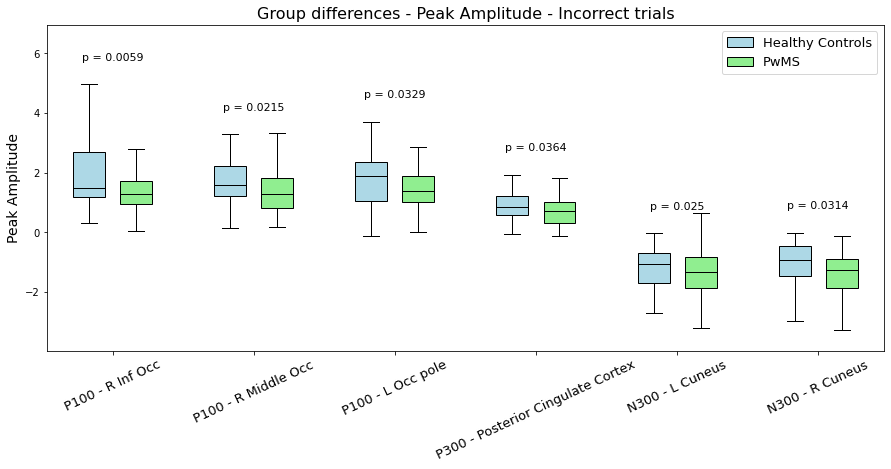

/tmp/ipykernel_3693931/3643328215.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_boxplot.append(np.array([np.array(data[peak_type][types].loc[(data[peak_type][types]['group'] == 'control')


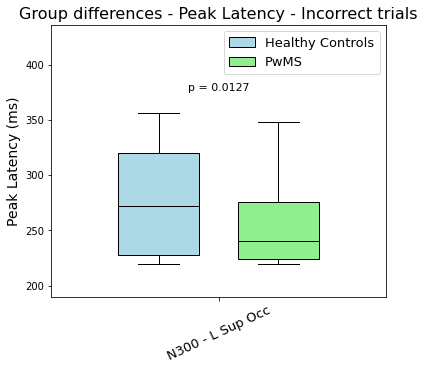

In [399]:
plotting_ERF_Amplitude_Latency(data=data, significant_differences=significant_differences_incorrect, event='incorrect', intervals_names=intervals_names)

# **Part 4. BRUMEG1 vs. BRUMEG2**

In [ ]:
# BRUMEG1 vs. BRUMEG2 can be identified by the amount of total channels in the file's info (38 MEG data channels + several STIM channels)
# It is the amount of STIM channels that is different between the device upgrage

for i in range(len(all_parceled)):
    print(i)
    print(mne.io.read_raw_fif(all_parceled[i], verbose=False).info['nchan'])   

In [ ]:
## 34 first subjects are from BRUMEG1

all_p_brumeg1 = all_parceled[0:33]
all_p_brumeg2 = all_parceled[33:]

dfs_brumeg1 = all_dfs_events[0:33]
dfs_brumeg2 = all_dfs_events[33:]

epochs_avg_BRUMEG1 = []
epochs_avg_BRUMEG2 = []

for subject in range(len(all_p_brumeg1)):
    # extract epoched data
    output_one = get_epochs_per_subject(all_p_brumeg1, nr_subject=subject, avg=True, fieldtrip_converted=False, df_events_all = dfs_brumeg1)
    epochs_avg_BRUMEG1.append(output_one)
    
for subject in range(len(all_p_brumeg2)):
    # extract epoched data
    output_two = get_epochs_per_subject(all_p_brumeg2, nr_subject=subject, avg=True, fieldtrip_converted=False, df_events_all = dfs_brumeg2)
    epochs_avg_BRUMEG2.append(output_two)

In [10]:
print(np.shape(epochs_avg_BRUMEG1))
print(np.shape(epochs_avg_BRUMEG2))

(33, 2)
(77, 2)


In [ ]:
check_all_CORR_BRU1 = [subject[0] for subject in epochs_avg_BRUMEG1]
check_all_INCORR_BRU1 = [subject[1] for subject in epochs_avg_BRUMEG1]
check_all_CORR_BRU2 = [subject[0] for subject in epochs_avg_BRUMEG2]
check_all_INCORR_BRU2 = [subject[1] for subject in epochs_avg_BRUMEG2]

# Calculate the grand average
GA_CORR_BRU1 = mne.grand_average(check_all_CORR_BRU1).get_data()
GA_INCORR_BRU1 = mne.grand_average(check_all_INCORR_BRU1).get_data()
GA_CORR_BRU2 = mne.grand_average(check_all_CORR_BRU2).get_data()
GA_INCORR_BRU2 = mne.grand_average(check_all_INCORR_BRU2).get_data()

fs = 250
t_start = 0.5
t_end = 1
t = np.arange(-t_start,t_end+1/fs,1/fs)

for i in range(len(parcel_idx)):
    fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(16,6))
    #Correct
    axs[0].plot(t,GA_CORR_BRU1[i],label='BRUMEG1')
    axs[0].plot(t,GA_CORR_BRU2[i],label='BRUMEG2')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Magnetic field contribution')
    axs[0].legend()
    axs[0].set_title(f'Grand average - Correct - {parcel_idx[i]} - {parcel_names[i]}') 
    #Incorrect
    axs[1].plot(t,GA_INCORR_BRU1[i],label='BRUMEG1')
    axs[1].plot(t,GA_INCORR_BRU2[i],label='BRUMEG2')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Magnetic field contribution')
    axs[1].legend()
    axs[1].set_title(f'Grand average - InCorrect - {parcel_idx[i]} - {parcel_names[i]}') 

### **Plot Power Spectral Density (PSD)**

In [ ]:
# Example: List of raw data objects for each subject
raw_list_brumeg1 = []
for i in range(len(all_p_brumeg1)):
    raw_list_brumeg1.append(mne.io.read_raw_fif(all_p_brumeg1[i], preload=True))

raw_list_brumeg2 = []
for i in range(len(all_p_brumeg2)):
    raw_list_brumeg2.append(mne.io.read_raw_fif(all_p_brumeg2[i], preload=True))    
    
# Initialize variables to store PSDs
all_psds_brumeg1 = []
all_psds_brumeg2 = []

# Loop through raw data objects
for raw in raw_list_brumeg1:
    # Compute PSD for each subject
    psd = raw.compute_psd(picks=parcel_idx, fmin=1, fmax=80)

    # Store the PSD values
    all_psds_brumeg1.append(psd.get_data(picks=parcel_idx))

# Loop through raw data objects
for raw in raw_list_brumeg2:
    # Compute PSD for each subject
    psd = raw.compute_psd(picks=parcel_idx, fmin=1, fmax=80)

    # Store the PSD values
    all_psds_brumeg2.append(psd.get_data(picks=parcel_idx))
    
# Convert the list of PSD arrays to a NumPy array
all_psds_brumeg1 = np.array(all_psds_brumeg1)
all_psds_brumeg2 = np.array(all_psds_brumeg2)

# Compute mean across subjects
mean_psd_brumeg1 = np.mean(all_psds_brumeg1, axis=0)
mean_psd_brumeg2 = np.mean(all_psds_brumeg2, axis=0)

30.06027820710973


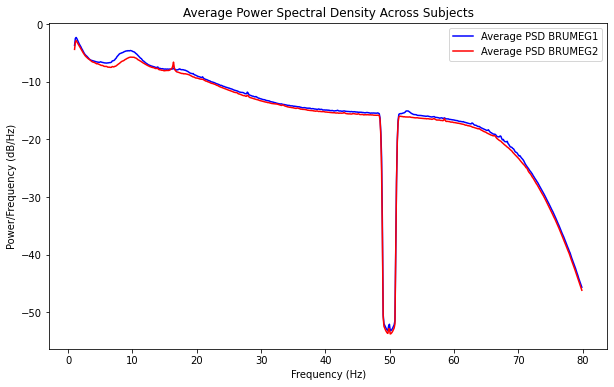

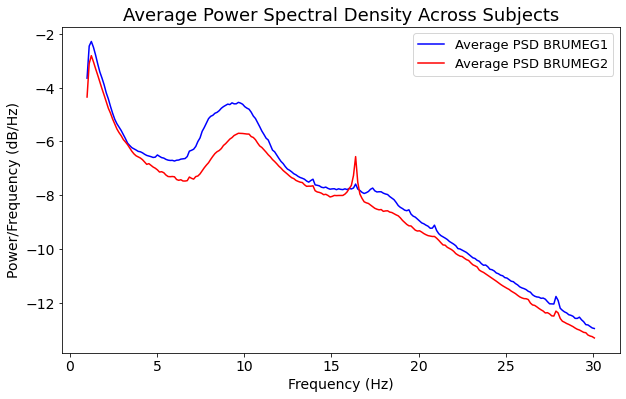

In [19]:
# Plot the average PSD
freq_increment = np.shape(mean_psd_brumeg1)[1]
freqs = np.arange(1, 80 - 1/freq_increment, (80-1)/freq_increment)

print(freqs[238])

plt.figure(figsize=(10, 6))
plt.plot(freqs, 10 * np.log10(np.mean(mean_psd_brumeg1,axis=0)), color='blue', label='Average PSD BRUMEG1')  # Convert to dB
plt.plot(freqs, 10 * np.log10(np.mean(mean_psd_brumeg2,axis=0)), color='red', label='Average PSD BRUMEG2')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Average Power Spectral Density Across Subjects')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(freqs[:239], 10 * np.log10(np.mean(mean_psd_brumeg1,axis=0))[:239], color='blue', label='Average PSD BRUMEG1')  # Convert to dB
plt.plot(freqs[:239], 10 * np.log10(np.mean(mean_psd_brumeg2,axis=0))[:239], color='red', label='Average PSD BRUMEG2')
plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('Power/Frequency (dB/Hz)', fontsize=14)
plt.title('Average Power Spectral Density Across Subjects', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=13)
#plt.legend()
plt.show()

### **Spectrum for each subject (to see if characterisation is the same)**

In [20]:
# Convert the list of PSD arrays to a NumPy array
avg_psd_per_sub_1 = [np.mean(all_psds_brumeg1[sub], axis=0) for sub in range(len(all_psds_brumeg1))]
avg_psd_per_sub_2 = [np.mean(all_psds_brumeg2[sub], axis=0) for sub in range(len(all_psds_brumeg2))]

/home/olivierb/FULLY_PROCESSED/processed_WITHOUT_orth/parc_2410_raw.fif
/home/olivierb/FULLY_PROCESSED/processed_WITHOUT_orth/parc_1082_raw.fif


Text(0.5, 1.0, 'Average PSD per sub - BRUMEG2')

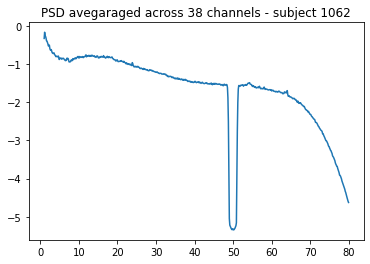

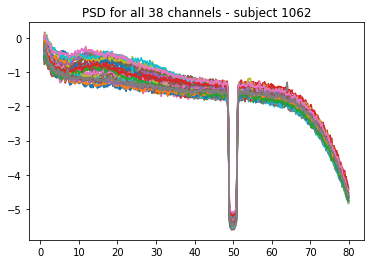

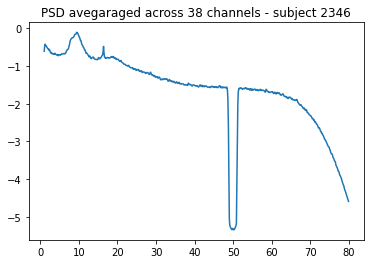

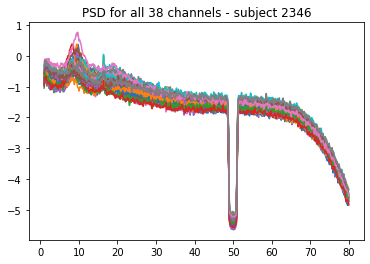

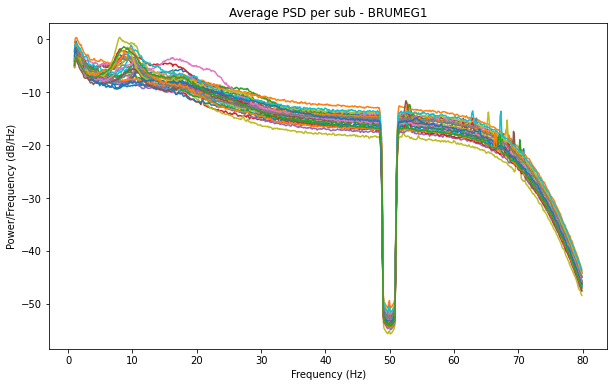

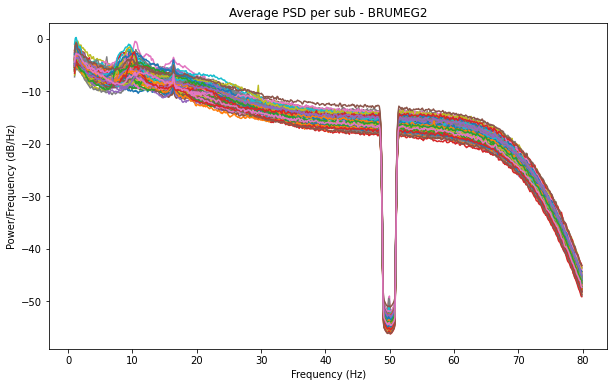

In [21]:
print(all_parceled[102])
print(all_parceled[30])

# Odd subject from BRUMEG1
plt.figure()
plt.plot(freqs,np.log10(avg_psd_per_sub_1[30]))
plt.title('PSD avegaraged across 38 channels - subject 1062')

plt.figure()
for i in range(len(all_psds_brumeg1[30])):
    plt.plot(freqs, np.log10(all_psds_brumeg1[30][i]))
plt.title('PSD for all 38 channels - subject 1062')


# Odd subject from BRUMEG2
plt.figure()
plt.plot(freqs,np.log10(avg_psd_per_sub_2[102-len(all_psds_brumeg1)]))
plt.title('PSD avegaraged across 38 channels - subject 2346')

plt.figure()
for i in range(len(all_psds_brumeg2[102-len(all_psds_brumeg1)])):
    plt.plot(freqs, np.log10(all_psds_brumeg2[102-len(all_psds_brumeg1)][i]))
plt.title('PSD for all 38 channels - subject 2346')


plt.figure(figsize=(10, 6))
for i in range(len(avg_psd_per_sub_1)):
    plt.plot(freqs, 10 * np.log10(avg_psd_per_sub_1[i]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Average PSD per sub - BRUMEG1')

plt.figure(figsize=(10, 6))
for i in range(len(avg_psd_per_sub_2)):
    plt.plot(freqs, 10 * np.log10(avg_psd_per_sub_2[i]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Average PSD per sub - BRUMEG2')

### Check ERF-average & PSD for: **HC and MS** seperately for BRUMEG1 vs. BRUMEG2:
- HC BRUMEG1 vs. HC BRUMEG2 AVG waveform (avg over 38 channels)
- idem for MS
- HC BRUMEG1 vs. HC BRUMEG2 AVG PSD (avg over 38 channels)
- idem for MS

In [22]:
control_idx_brumeg_1 = [idx for idx in df_control_idx if idx < 33]  # 0 until 32 included -> 33 subjects
ms_idx_brumeg_1 = [idx for idx in df_ms_idx if idx < 33]

control_idx_brumeg_2 = [idx for idx in df_control_idx if idx >= 33] # 34 until end -> 110 - 33 = 77 subjects
ms_idx_brumeg_2 = [idx for idx in df_ms_idx if idx >= 33]

# check
print(len(control_idx_brumeg_1) + len(ms_idx_brumeg_1) + len(control_idx_brumeg_2) + len(ms_idx_brumeg_2))

110


In [ ]:
HC_all_CORR_BRU1 = [epochs_AVG[control_idx][0] for control_idx in control_idx_brumeg_1]
HC_all_INCORR_BRU1 = [epochs_AVG[control_idx][1] for control_idx in control_idx_brumeg_1]
HC_all_CORR_BRU2 = [epochs_AVG[control_idx][0] for control_idx in control_idx_brumeg_2]
HC_all_INCORR_BRU2 = [epochs_AVG[control_idx][1] for control_idx in control_idx_brumeg_2]

MS_all_CORR_BRU1 = [epochs_AVG[ms_idx][0] for ms_idx in ms_idx_brumeg_1]
MS_all_INCORR_BRU1 = [epochs_AVG[ms_idx][1] for ms_idx in ms_idx_brumeg_1]
MS_all_CORR_BRU2 = [epochs_AVG[ms_idx][0] for ms_idx in ms_idx_brumeg_2]
MS_all_INCORR_BRU2 = [epochs_AVG[ms_idx][1] for ms_idx in ms_idx_brumeg_2]

# Calculate the grand average
GA_HC_CORR_BRU1 = mne.grand_average(HC_all_CORR_BRU1).get_data()
GA_HC_INCORR_BRU1 = mne.grand_average(HC_all_INCORR_BRU1).get_data()
GA_HC_CORR_BRU2 = mne.grand_average(HC_all_CORR_BRU2).get_data()
GA_HC_INCORR_BRU2 = mne.grand_average(HC_all_INCORR_BRU2).get_data()

fs = 250
t_start = 0.5
t_end = 1
t = np.arange(-t_start,t_end+1/fs,1/fs)

for i in range(len(parcel_idx)):
    fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(16,6))
    #Correct
    axs[0].plot(t,GA_HC_CORR_BRU1[i],label='HC BRUMEG1')
    axs[0].plot(t,GA_HC_CORR_BRU2[i],label='HC BRUMEG2')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Magnetic field contribution')
    axs[0].legend()
    axs[0].set_title(f'Grand average - Correct - {parcel_idx[i]} - {parcel_names[i]}') 
    #Incorrect
    axs[1].plot(t,GA_HC_INCORR_BRU1[i],label='HC BRUMEG1')
    axs[1].plot(t,GA_HC_INCORR_BRU2[i],label='HC BRUMEG2')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Magnetic field contribution')
    axs[1].legend()
    axs[1].set_title(f'Grand average - InCorrect - {parcel_idx[i]} - {parcel_names[i]}') 
fig.suptitle('BRUMEG1 vs. BRUMEG2 for Healthy Controls')

In [ ]:
# Calculate the grand average
GA_MS_CORR_BRU1 = mne.grand_average(MS_all_CORR_BRU1).get_data()
GA_MS_INCORR_BRU1 = mne.grand_average(MS_all_INCORR_BRU1).get_data()
GA_MS_CORR_BRU2 = mne.grand_average(MS_all_CORR_BRU2).get_data()
GA_MS_INCORR_BRU2 = mne.grand_average(MS_all_INCORR_BRU2).get_data()

fs = 250
t_start = 0.5
t_end = 1
t = np.arange(-t_start,t_end+1/fs,1/fs)

for i in range(len(parcel_idx)):
    fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(16,6))
    #Correct
    axs[0].plot(t,GA_MS_CORR_BRU1[i],label='PwMS BRUMEG1')
    axs[0].plot(t,GA_MS_CORR_BRU2[i],label='PwMS BRUMEG2')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Magnetic field contribution')
    axs[0].legend()
    axs[0].set_title(f'Grand average - Correct - {parcel_idx[i]} - {parcel_names[i]}') 
    #Incorrect
    axs[1].plot(t,GA_MS_INCORR_BRU1[i],label='PwMS BRUMEG1')
    axs[1].plot(t,GA_MS_INCORR_BRU2[i],label='PwMS BRUMEG2')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Magnetic field contribution')
    axs[1].legend()
    axs[1].set_title(f'Grand average - InCorrect - {parcel_idx[i]} - {parcel_names[i]}') 
fig.suptitle('BRUMEG1 vs. BRUMEG2 for PwMS')

In [32]:
assignments = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
               2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1,
               1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1]

Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


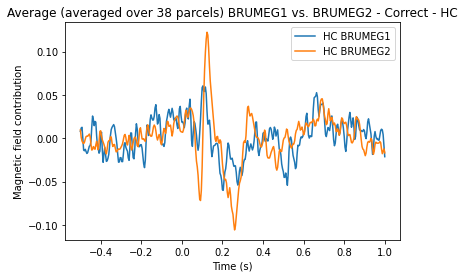

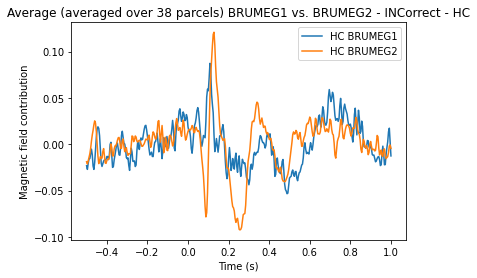

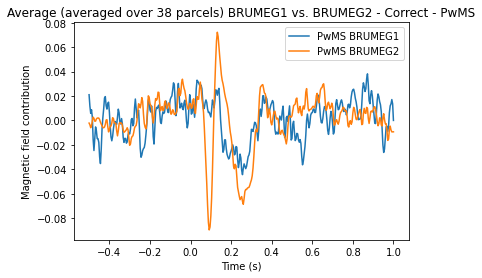

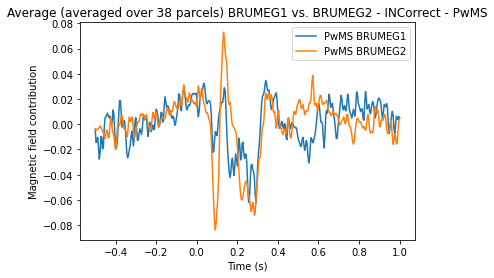

In [29]:
GA_HC_CORR_BRU1 = np.mean(mne.grand_average(HC_all_CORR_BRU1).get_data(), axis=0)
GA_HC_INCORR_BRU1 = np.mean(mne.grand_average(HC_all_INCORR_BRU1).get_data(), axis=0)
GA_HC_CORR_BRU2 = np.mean(mne.grand_average(HC_all_CORR_BRU2).get_data(), axis=0)
GA_HC_INCORR_BRU2 = np.mean(mne.grand_average(HC_all_INCORR_BRU2).get_data(), axis=0)

GA_MS_CORR_BRU1 = np.mean(mne.grand_average(MS_all_CORR_BRU1).get_data(), axis=0)
GA_MS_INCORR_BRU1 = np.mean(mne.grand_average(MS_all_INCORR_BRU1).get_data(), axis=0)
GA_MS_CORR_BRU2 = np.mean(mne.grand_average(MS_all_CORR_BRU2).get_data(), axis=0)
GA_MS_INCORR_BRU2 = np.mean(mne.grand_average(MS_all_INCORR_BRU2).get_data(), axis=0)

plt.figure()
plt.title('Average (averaged over 38 parcels) BRUMEG1 vs. BRUMEG2 - Correct - HC')
plt.plot(t, GA_HC_CORR_BRU1, label='HC BRUMEG1')
plt.plot(t, GA_HC_CORR_BRU2, label='HC BRUMEG2')
plt.xlabel('Time (s)')
plt.ylabel('Magnetic field contribution')
plt.legend()

plt.figure()
plt.title('Average (averaged over 38 parcels) BRUMEG1 vs. BRUMEG2 - INCorrect - HC')
plt.plot(t, GA_HC_INCORR_BRU1, label='HC BRUMEG1')
plt.plot(t, GA_HC_INCORR_BRU2, label='HC BRUMEG2')
plt.xlabel('Time (s)')
plt.ylabel('Magnetic field contribution')
plt.legend()

plt.figure()
plt.title('Average (averaged over 38 parcels) BRUMEG1 vs. BRUMEG2 - Correct - PwMS')
plt.plot(t, GA_MS_CORR_BRU1, label='PwMS BRUMEG1')
plt.plot(t, GA_MS_CORR_BRU2, label='PwMS BRUMEG2')
plt.xlabel('Time (s)')
plt.ylabel('Magnetic field contribution')

plt.legend()


plt.figure()
plt.title('Average (averaged over 38 parcels) BRUMEG1 vs. BRUMEG2 - INCorrect - PwMS')
plt.plot(t, GA_MS_INCORR_BRU1, label='PwMS BRUMEG1')
plt.plot(t, GA_MS_INCORR_BRU2, label='PwMS BRUMEG2')
plt.xlabel('Time (s)')
plt.ylabel('Magnetic field contribution')
plt.legend()

### **With statistically significant differences time point by time point** 

### **HC - correct trials**

In [50]:
a = [np.mean(HC_all_CORR_BRU1[sub].get_data(),axis=0) for sub in range(len(HC_all_CORR_BRU1))]
b = [np.mean(HC_all_CORR_BRU2[sub].get_data(),axis=0) for sub in range(len(HC_all_CORR_BRU2))]

assignment_HC = []
for i in range(len(a)):
    assignment_HC.append(1)
for i in range(len(b)):
    assignment_HC.append(2)

hc_corr = np.concatenate([a,b])
print(np.shape(hc_corr))

diff, pvals = group_diff_max_stat_perm(data=hc_corr, assignments=assignment_HC, n_perm=10000)
print("Number of significant differences:", np.sum(pvals < 0.05))

(37, 376)
Permuting contrast <class 'glmtools.design.Contrast'>(GroupDiff,Differential) with mode=row-shuffle
	Computing 10000 permutations
	Taking max-stat across ['features 1'] dimensions
Using tstats as metric
Number of significant differences: 0


### **HC - incorrect trials**

In [51]:
c = [np.mean(HC_all_INCORR_BRU1[sub].get_data(),axis=0) for sub in range(len(HC_all_INCORR_BRU1))]
d = [np.mean(HC_all_INCORR_BRU2[sub].get_data(),axis=0) for sub in range(len(HC_all_INCORR_BRU2))]

assignment_HC = []
for i in range(len(c)):
    assignment_HC.append(1)
for i in range(len(d)):
    assignment_HC.append(2)

hc_incorr = np.concatenate([c,d])
print(np.shape(hc_incorr))

diff, pvals = group_diff_max_stat_perm(data=hc_incorr, assignments=assignment_HC, n_perm=10000)
print("Number of significant differences:", np.sum(pvals < 0.05))

(37, 376)
Permuting contrast <class 'glmtools.design.Contrast'>(GroupDiff,Differential) with mode=row-shuffle
	Computing 10000 permutations
	Taking max-stat across ['features 1'] dimensions
Using tstats as metric
Number of significant differences: 0


### **PwMS - correct trials**

In [53]:
e = [np.mean(MS_all_CORR_BRU1[sub].get_data(),axis=0) for sub in range(len(MS_all_CORR_BRU1))]
f = [np.mean(MS_all_CORR_BRU2[sub].get_data(),axis=0) for sub in range(len(MS_all_CORR_BRU2))]

assignment_MS = []
for i in range(len(e)):
    assignment_MS.append(1)
for i in range(len(f)):
    assignment_MS.append(2)

ms_corr = np.concatenate([e,f])
print(np.shape(ms_corr))

diff, pvals = group_diff_max_stat_perm(data=ms_corr, assignments=assignment_MS, n_perm=10000)
print("Number of significant differences:", np.sum(pvals < 0.05))

(73, 376)
Permuting contrast <class 'glmtools.design.Contrast'>(GroupDiff,Differential) with mode=row-shuffle
	Computing 10000 permutations
	Taking max-stat across ['features 1'] dimensions
Using tstats as metric
Number of significant differences: 0


### **PwMS - in=correct trials**

In [54]:
g = [np.mean(MS_all_INCORR_BRU1[sub].get_data(),axis=0) for sub in range(len(MS_all_INCORR_BRU1))]
h = [np.mean(MS_all_INCORR_BRU2[sub].get_data(),axis=0) for sub in range(len(MS_all_INCORR_BRU2))]

assignment_MS = []
for i in range(len(g)):
    assignment_MS.append(1)
for i in range(len(h)):
    assignment_MS.append(2)

ms_incorr = np.concatenate([g,h])
print(np.shape(ms_incorr))

diff, pvals = group_diff_max_stat_perm(data=ms_incorr, assignments=assignment_MS, n_perm=10000)
print("Number of significant differences:", np.sum(pvals < 0.05))

(73, 376)
Permuting contrast <class 'glmtools.design.Contrast'>(GroupDiff,Differential) with mode=row-shuffle
	Computing 10000 permutations
	Taking max-stat across ['features 1'] dimensions
Using tstats as metric
Number of significant differences: 0


### PSD

In [98]:
# Start from "all_psds_brumeg2"
all_psds = np.concatenate([all_psds_brumeg1, all_psds_brumeg2])

control_PSDs_1 = [all_psds[sub] for sub in control_idx_brumeg_1]
ms_PSDs_1 = [all_psds[sub] for sub in ms_idx_brumeg_1]
control_PSDs_2 = [all_psds[sub] for sub in control_idx_brumeg_2]
ms_PSDs_2 = [all_psds[sub] for sub in ms_idx_brumeg_2]

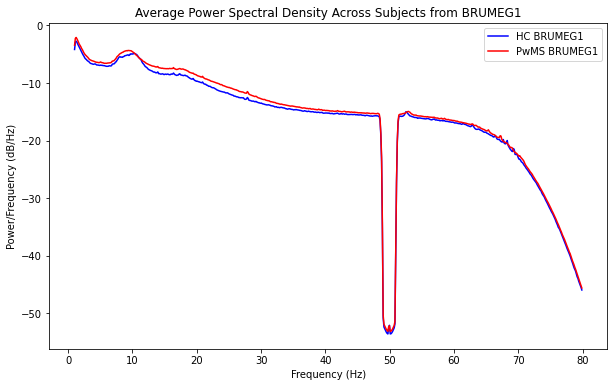

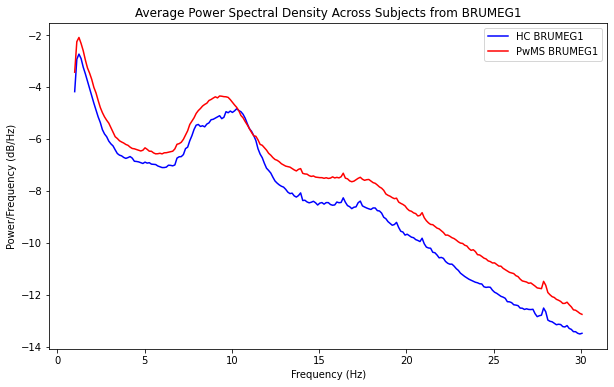

In [99]:
# Compute mean across subjects
mean_psd_control_1 = np.mean(control_PSDs_1, axis=0)
mean_psd_ms_1 = np.mean(ms_PSDs_1, axis=0)

# Plot the average PSD
freq_increment = np.shape(mean_psd_control_1)[1]
freqs = np.arange(1, 80 - 1/freq_increment, (80-1)/freq_increment)

plt.figure(figsize=(10, 6))
plt.plot(freqs, 10 * np.log10(np.mean(mean_psd_control_1,axis=0)), color='blue', label='HC BRUMEG1')  # Convert to dB
plt.plot(freqs, 10 * np.log10(np.mean(mean_psd_ms_1,axis=0)), color='red', label='PwMS BRUMEG1')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Average Power Spectral Density Across Subjects from BRUMEG1')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(freqs[:239], 10 * np.log10(np.mean(mean_psd_control_1,axis=0))[:239], color='blue', label='HC BRUMEG1')  # Convert to dB
plt.plot(freqs[:239], 10 * np.log10(np.mean(mean_psd_ms_1,axis=0))[:239], color='red', label='PwMS BRUMEG1')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Average Power Spectral Density Across Subjects from BRUMEG1')
plt.legend()
plt.show()

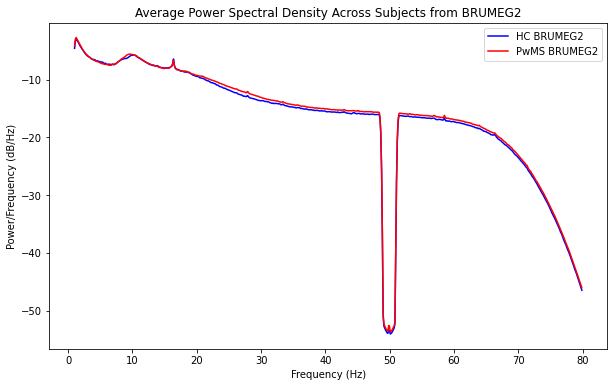

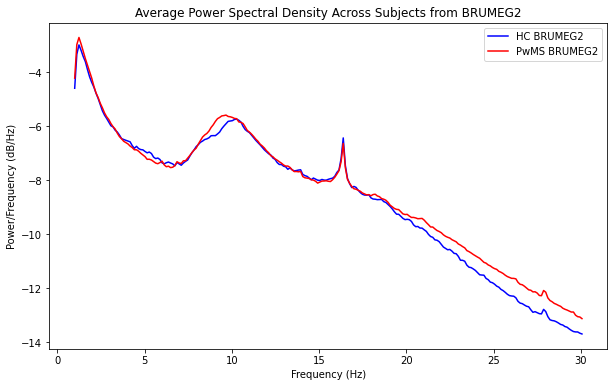

In [100]:
# Compute mean across subjects
mean_psd_control_2 = np.mean(control_PSDs_2, axis=0)
mean_psd_ms_2 = np.mean(ms_PSDs_2, axis=0)

# Plot the average PSD
freq_increment = np.shape(mean_psd_control_2)[1]
freqs = np.arange(1, 80 - 1/freq_increment, (80-1)/freq_increment)

plt.figure(figsize=(10, 6))
plt.plot(freqs, 10 * np.log10(np.mean(mean_psd_control_2,axis=0)), color='blue', label='HC BRUMEG2')  # Convert to dB
plt.plot(freqs, 10 * np.log10(np.mean(mean_psd_ms_2,axis=0)), color='red', label='PwMS BRUMEG2')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Average Power Spectral Density Across Subjects from BRUMEG2')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(freqs[:239], 10 * np.log10(np.mean(mean_psd_control_2,axis=0))[:239], color='blue', label='HC BRUMEG2')  # Convert to dB
plt.plot(freqs[:239], 10 * np.log10(np.mean(mean_psd_ms_2,axis=0))[:239], color='red', label='PwMS BRUMEG2')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Average Power Spectral Density Across Subjects from BRUMEG2')
plt.legend()
plt.show()

### Check ERF-average & PSD for: **MALES and FEMALES** seperately for **BRUMEG2**

In [101]:
## Extract gender info

df_patientinfo = patientinfo_to_df("/home/olivierb/Downloads/subjectinfo.mat")
display(df_patientinfo)

# Get only 124 subjects for which we have both parceled MEG data & eventtables
filtered_df = df_patientinfo[df_patientinfo['code'].isin(subject_IDs_group_analysis)].reset_index(drop=True)

# Get all row indices with isms = 0 ==> healthy controls
df_male_idx = filtered_df.index[filtered_df['gender_isfemale'] == 0].tolist()
print(df_male_idx)
print(len(df_male_idx))

# Get all row indices with isms = 1 ==> MS patients
df_female_idx = filtered_df.index[filtered_df['gender_isfemale'] == 1].tolist()
#print(df_ms_idx)
print(len(df_female_idx))
print(df_female_idx)

code  disdur  type        age  edu  SDMT  gender_isfemale  isms  EDSS  \
0    0921    15.0  RRMS  34.046107   15    55                1     1   2.5   
1    0922    13.0  RRMS  40.803307   13    46                1     1   2.5   
2    0925     9.0  RRMS  33.211039   15    50                1     1   2.5   
3    0930    26.0  RRMS  48.710437   15    57                1     1   2.0   
4    0944    24.0  RRMS  55.002190    8    53                1     1   1.0   
..    ...     ...   ...        ...  ...   ...              ...   ...   ...   
145  2427     NaN   NaN  54.131530   12    64                0     0   NaN   
146  2431    20.0  PPMS  66.000438   15    19                0     1   6.5   
147  2440    12.0  RRMS  37.898368   12    50                0     1   3.5   
148  2447    10.0  RRMS  44.017632   15    43                1     1   1.5   
149  2448     NaN   NaN  63.100975   12    38                1     0   NaN   

     benzos  
0         1  
1         0  
2         0  
3         0  
4         0  
..      ...  
145       0  
146       0  
147       0  
148       0  
149       0  

[150 rows x 10 columns]

[38, 39, 41, 47, 48, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 69, 70, 72, 73, 74, 76, 79, 81, 83, 84, 87, 91, 99, 100, 101, 102, 104, 106, 107]
34
76
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 42, 43, 44, 45, 46, 49, 50, 51, 52, 53, 54, 55, 60, 67, 68, 71, 75, 77, 78, 80, 82, 85, 86, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 103, 105, 108, 109]


In [102]:
male_idx_brumeg_1 = [idx for idx in df_male_idx if idx < 33]  # 0 until 32 included -> 33 subjects
female_idx_brumeg_1 = [idx for idx in df_female_idx if idx < 33]

male_idx_brumeg_2 = [idx for idx in df_male_idx if idx >= 33] # 32 until end -> 110 - 33 = = 77 subjects
female_idx_brumeg_2 = [idx for idx in df_female_idx if idx >= 33]

# check
print(len(male_idx_brumeg_1) + len(female_idx_brumeg_1) + len(male_idx_brumeg_2) + len(female_idx_brumeg_2))

110


[]
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...
Identifying common channels ...


/tmp/ipykernel_2824157/1399196138.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(16,6))


Text(0.5, 0.98, 'MALES VS FEMALES FOR BRUMEG2')

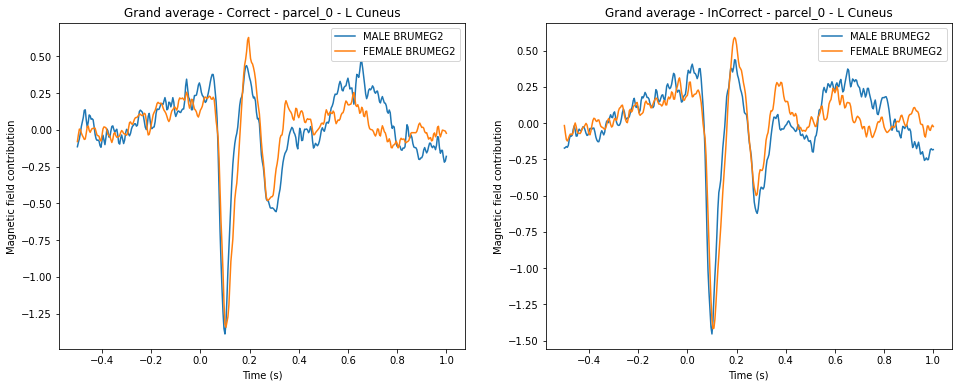

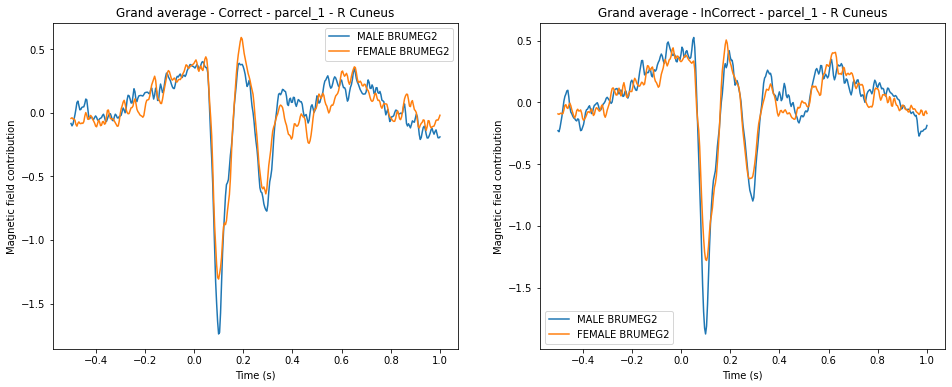

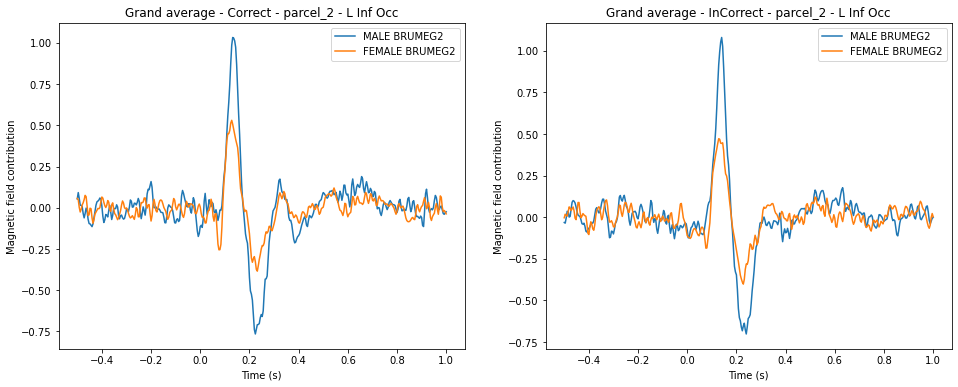

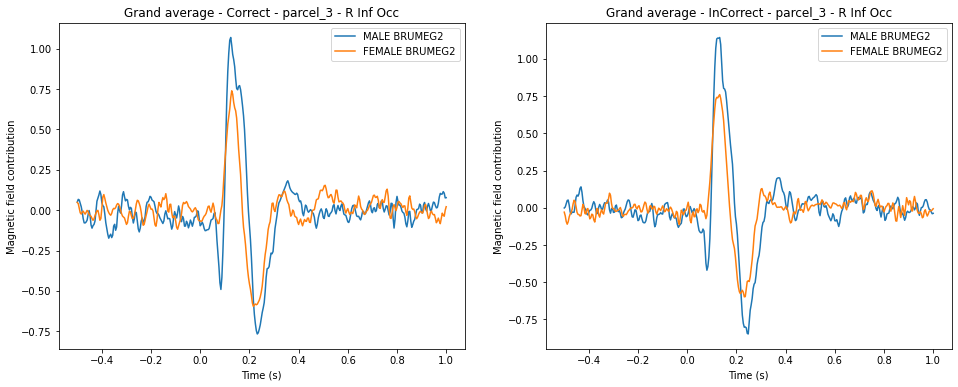

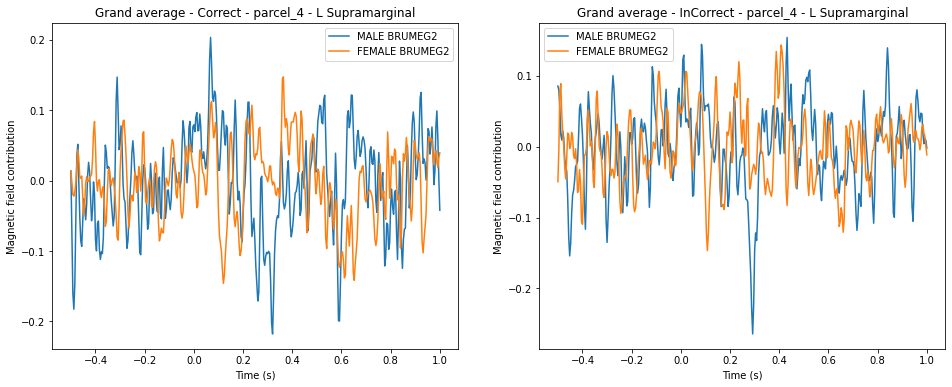

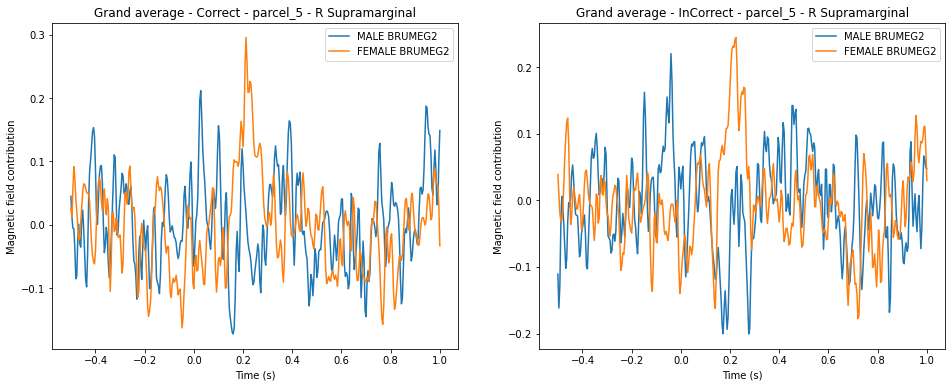

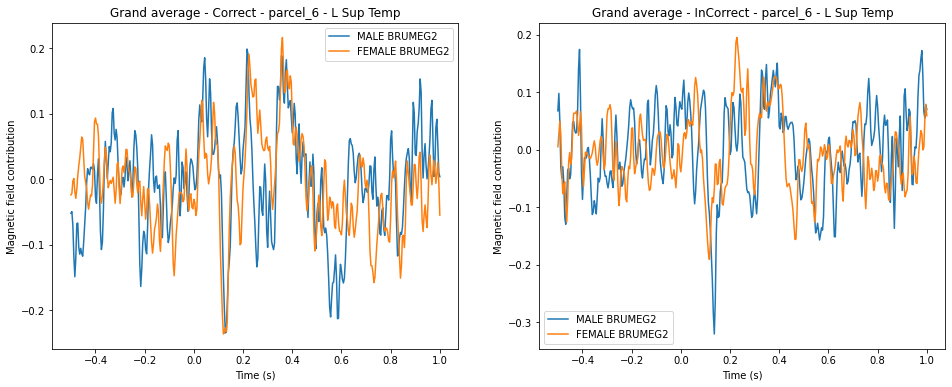

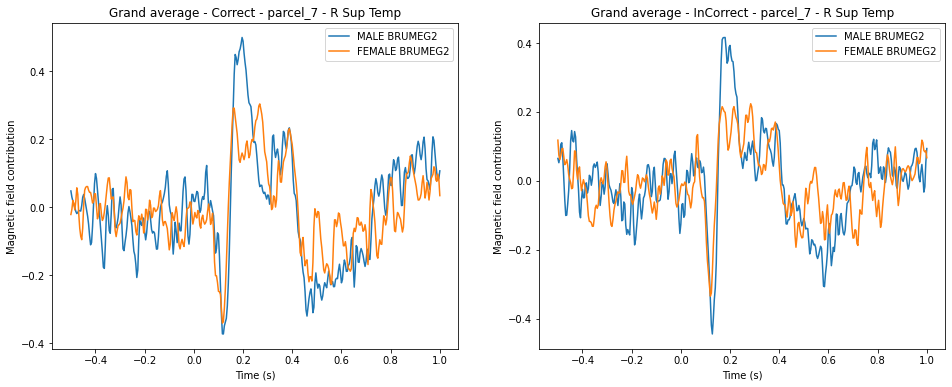

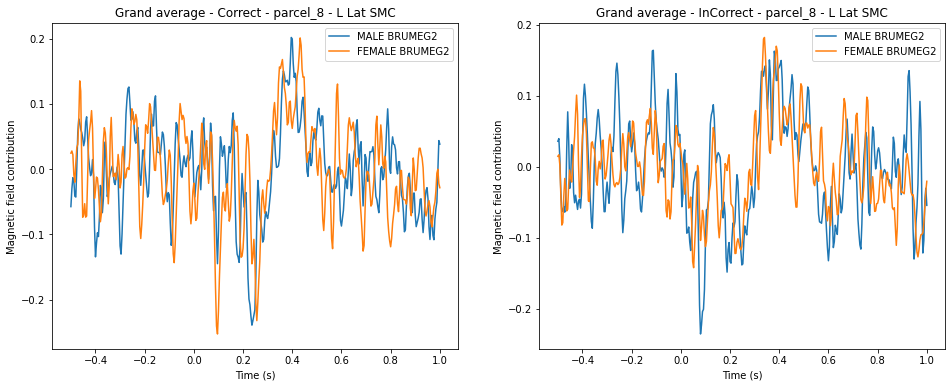

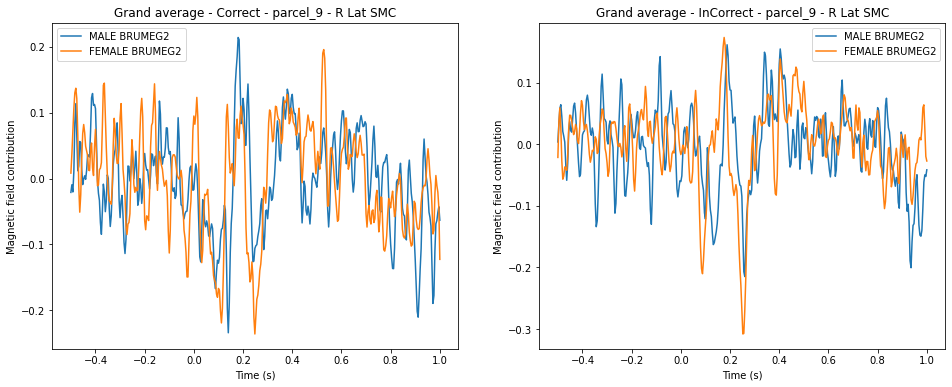

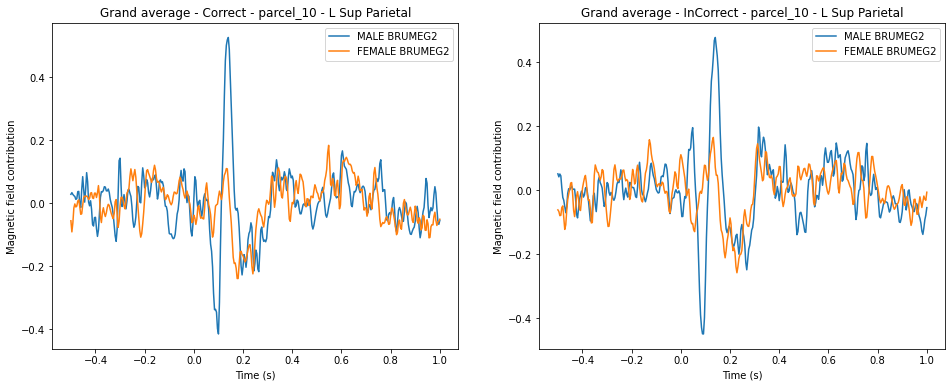

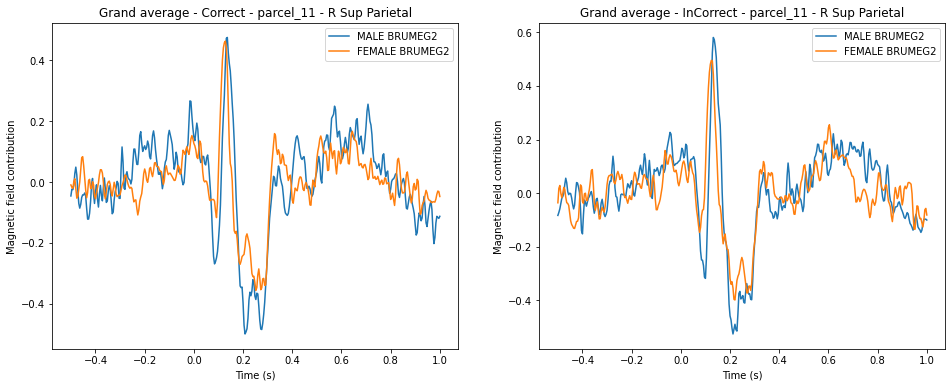

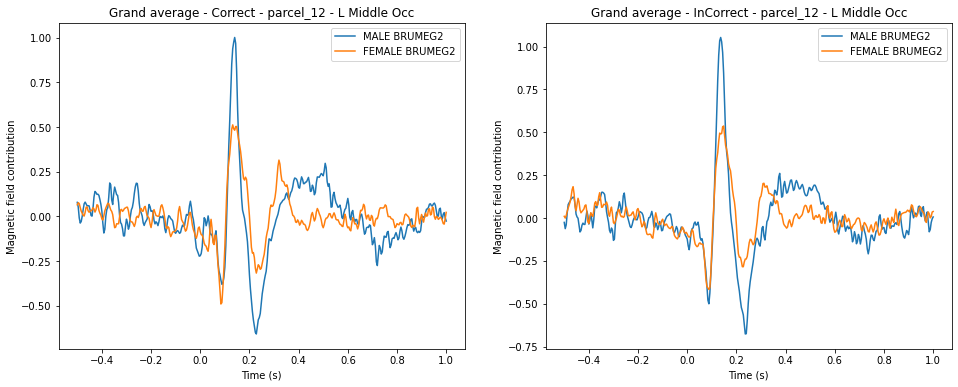

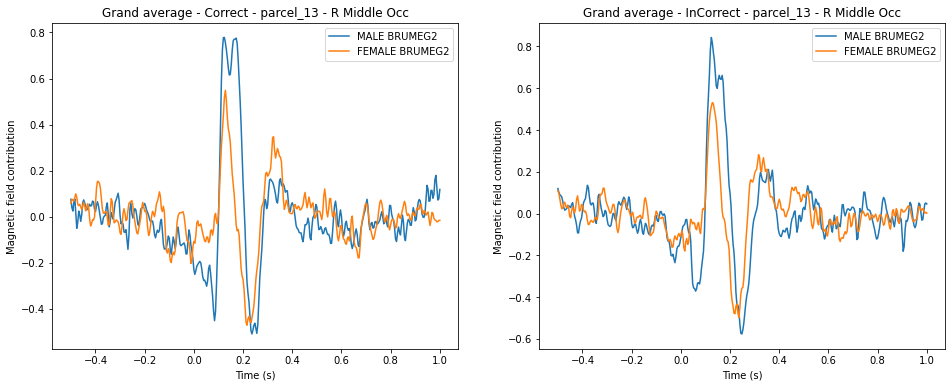

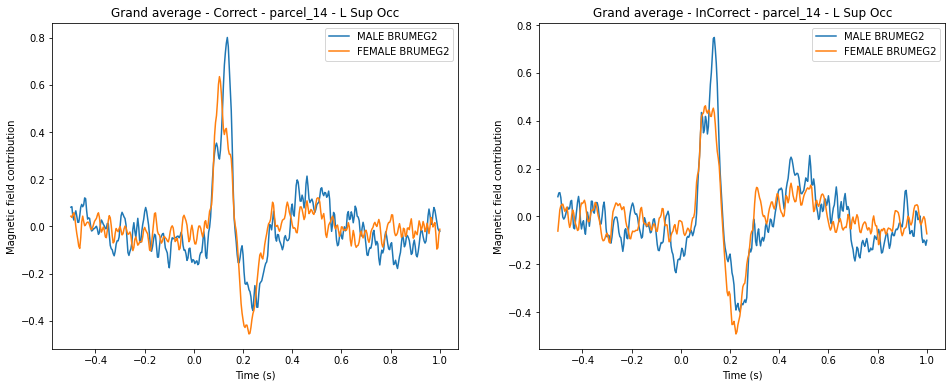

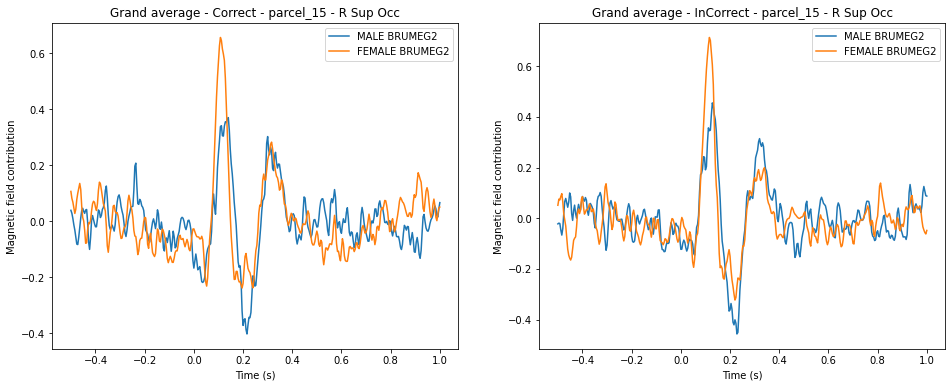

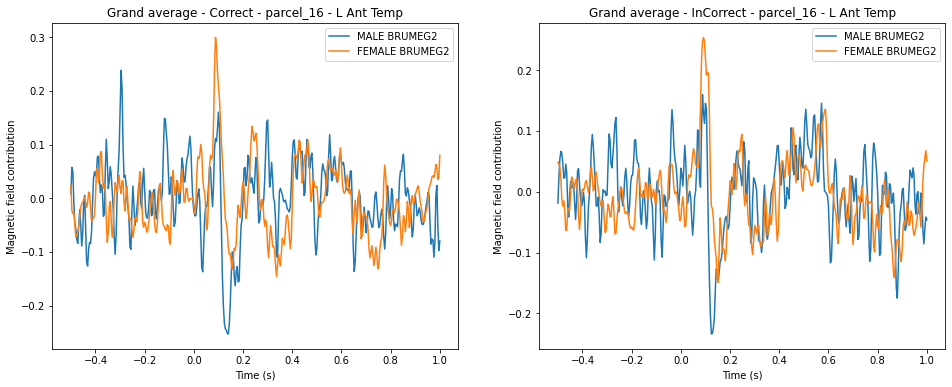

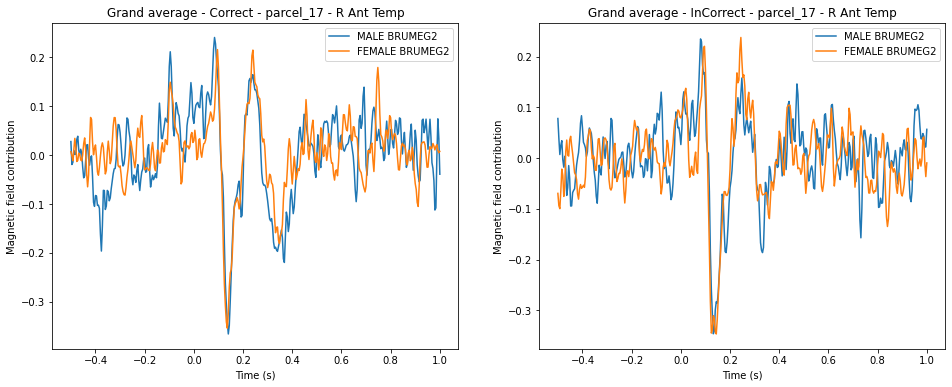

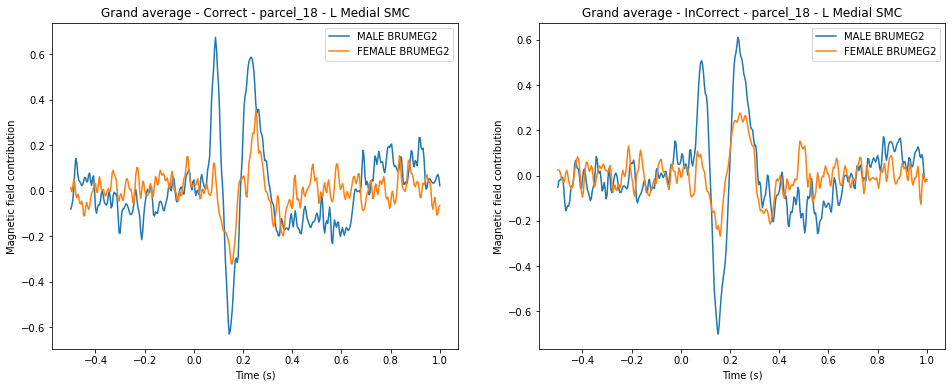

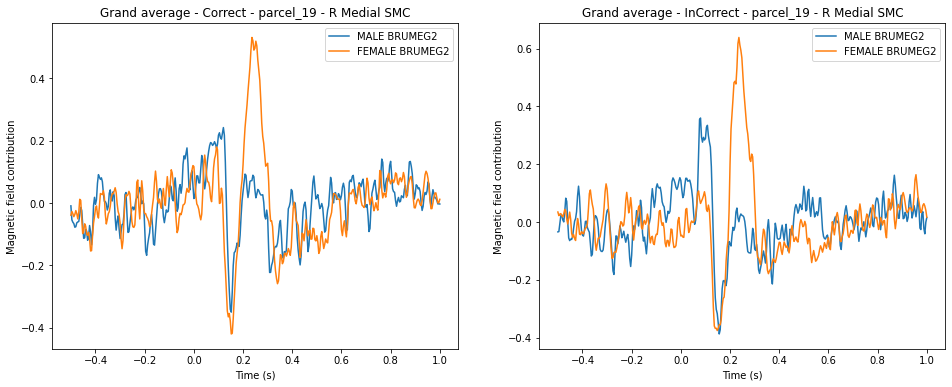

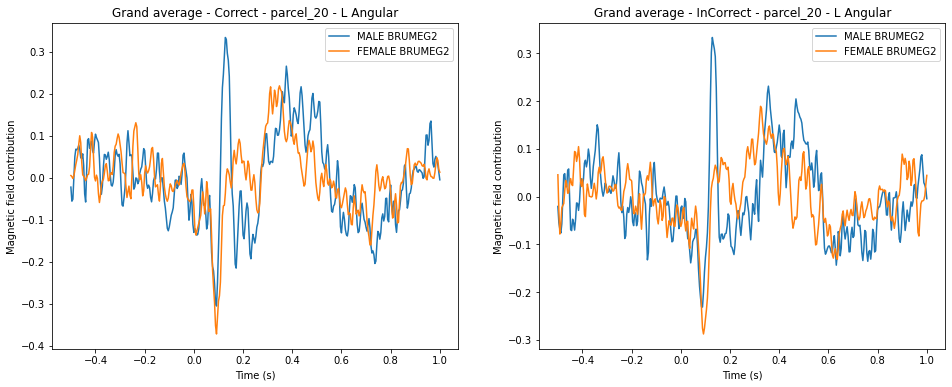

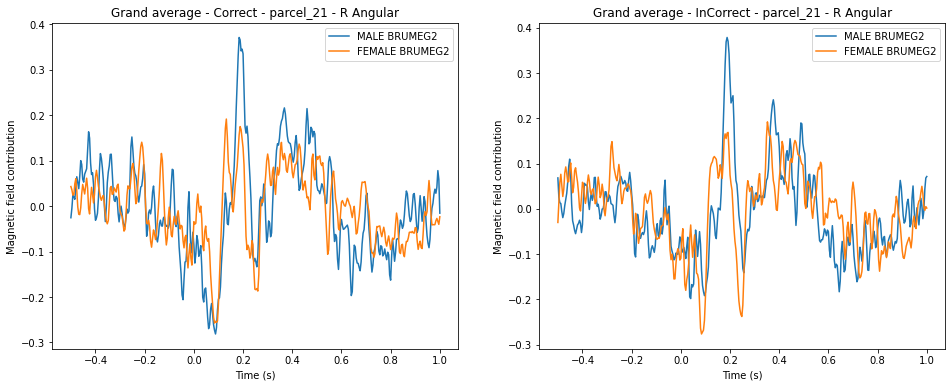

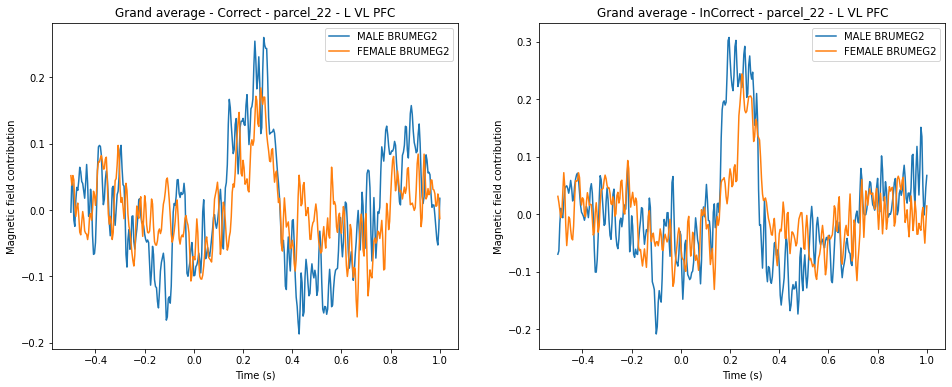

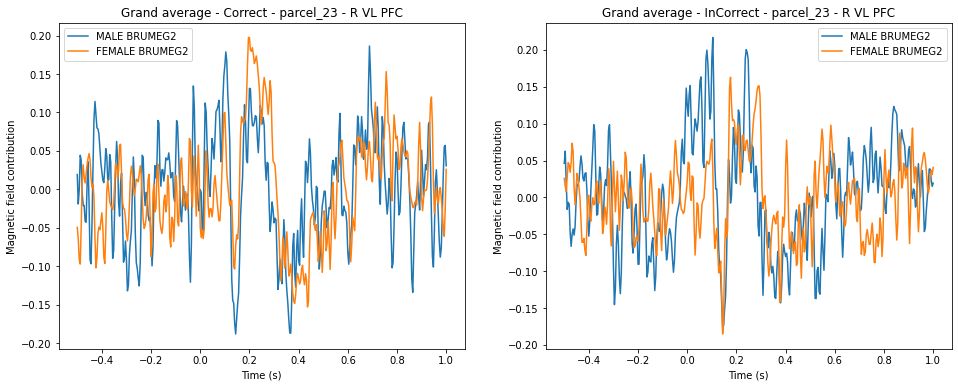

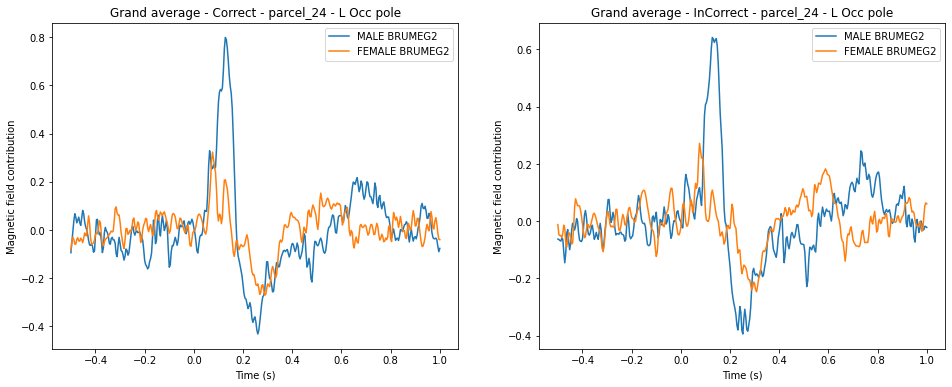

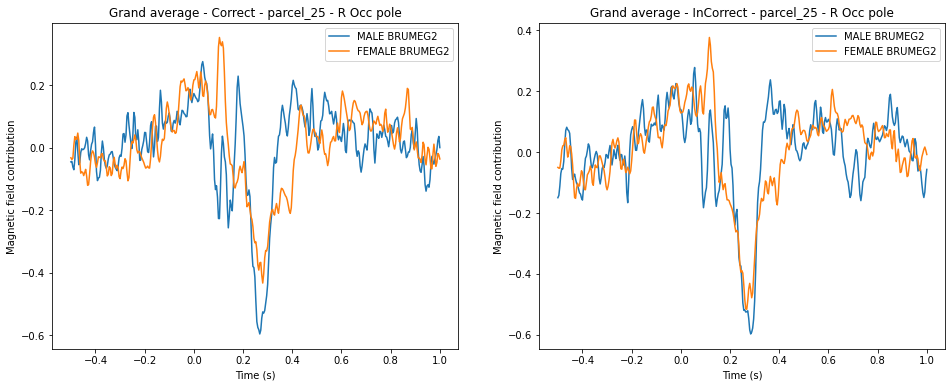

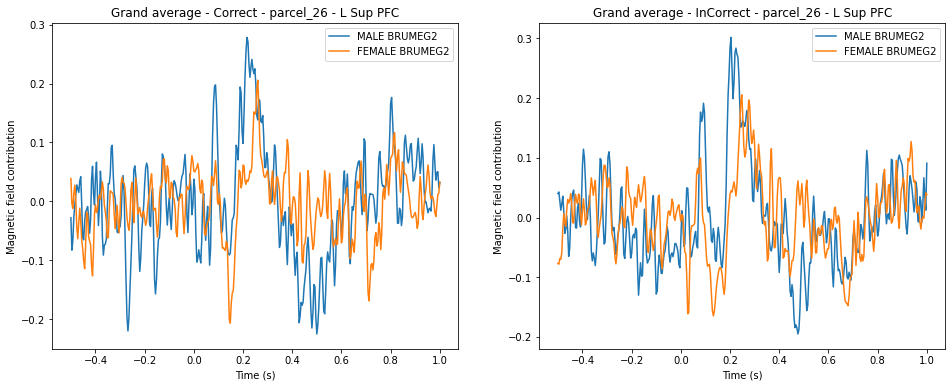

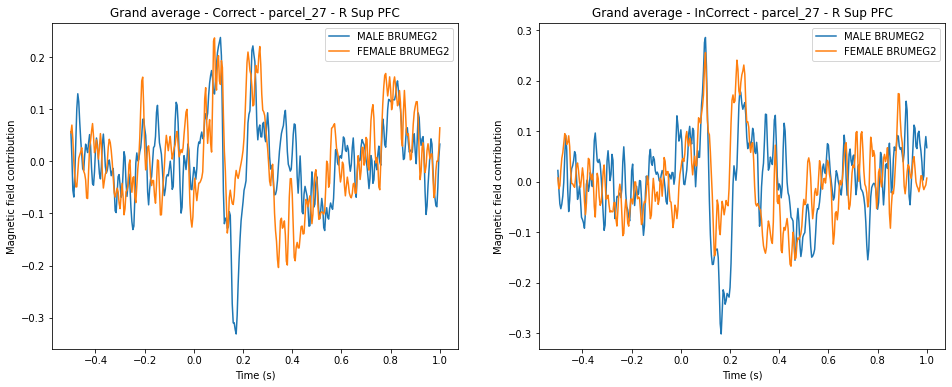

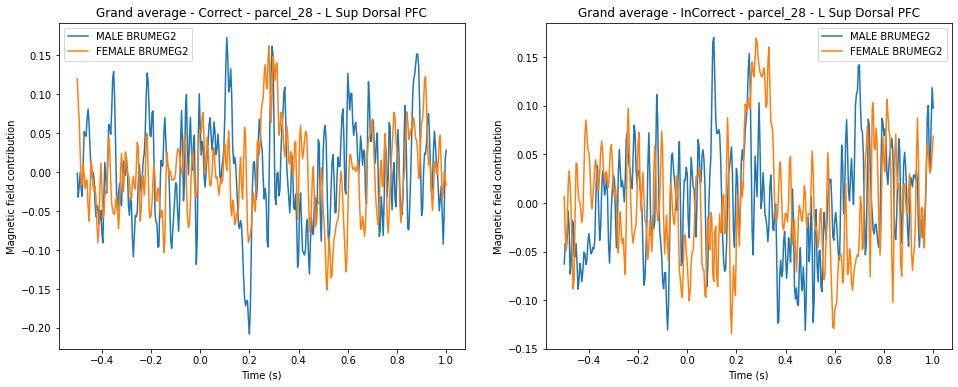

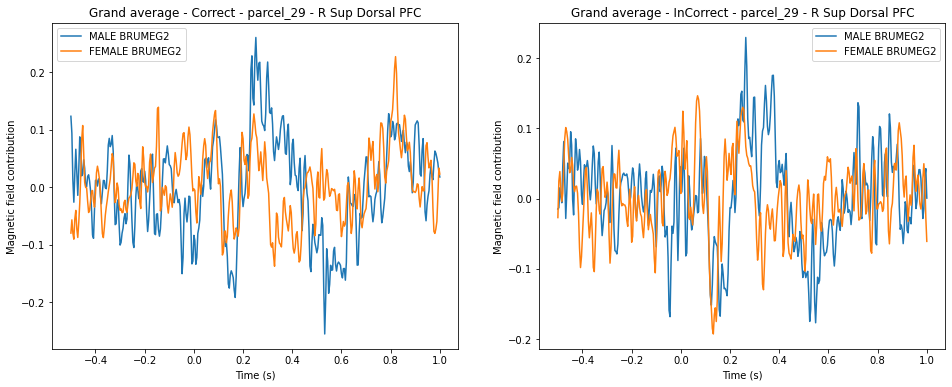

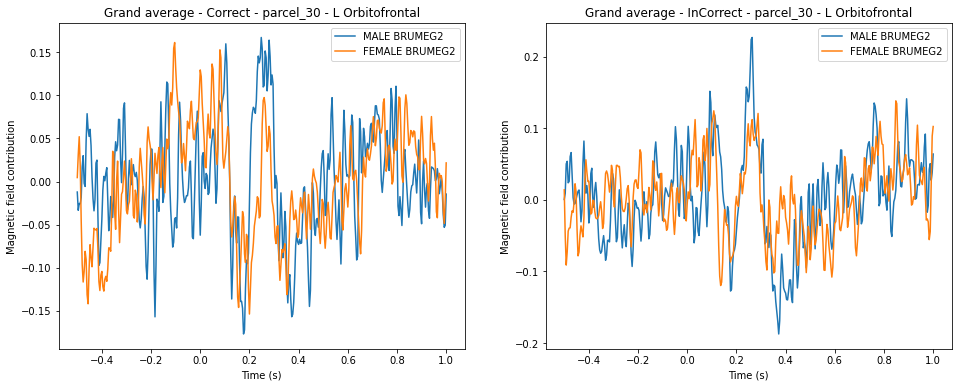

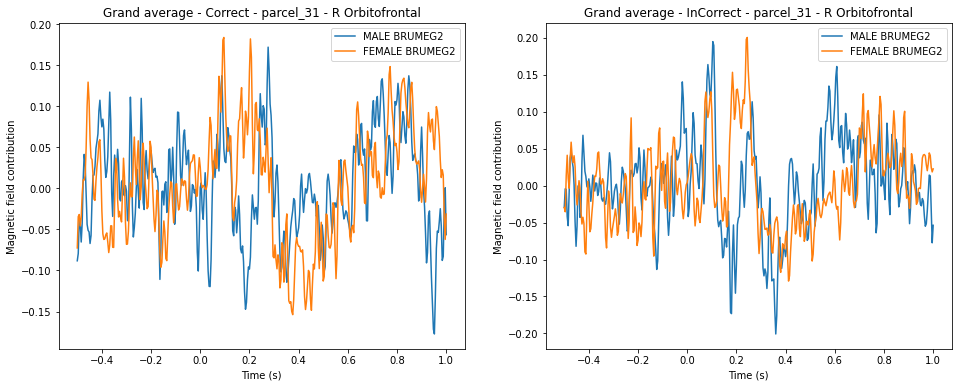

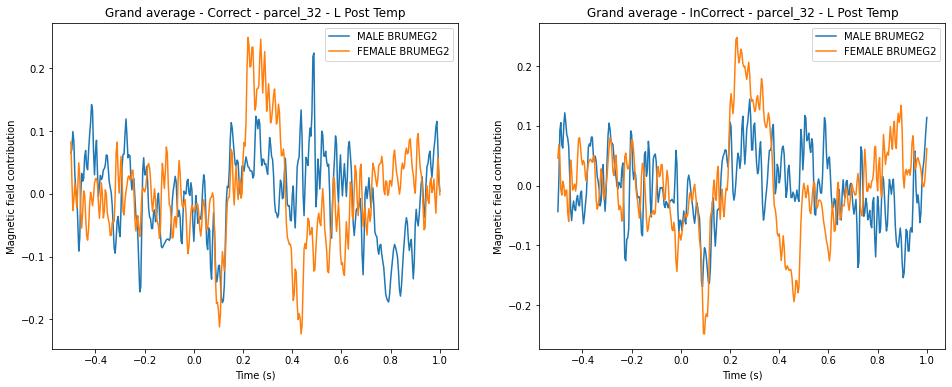

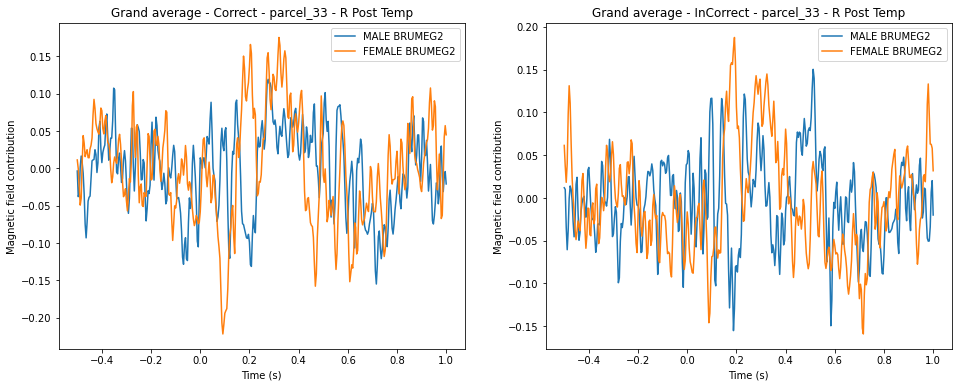

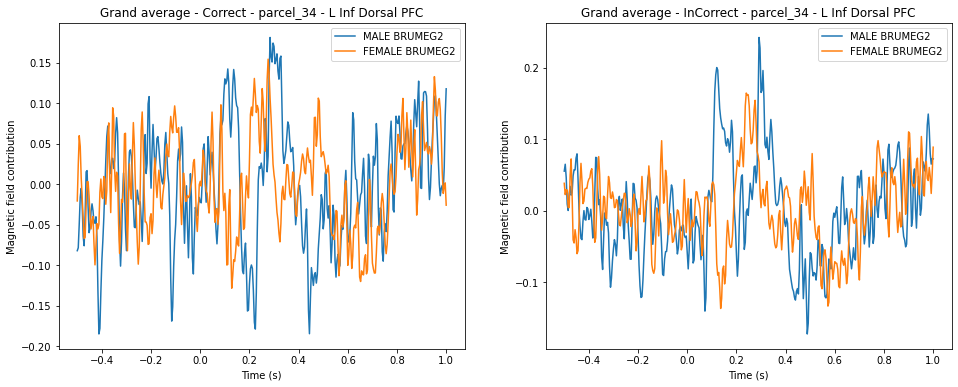

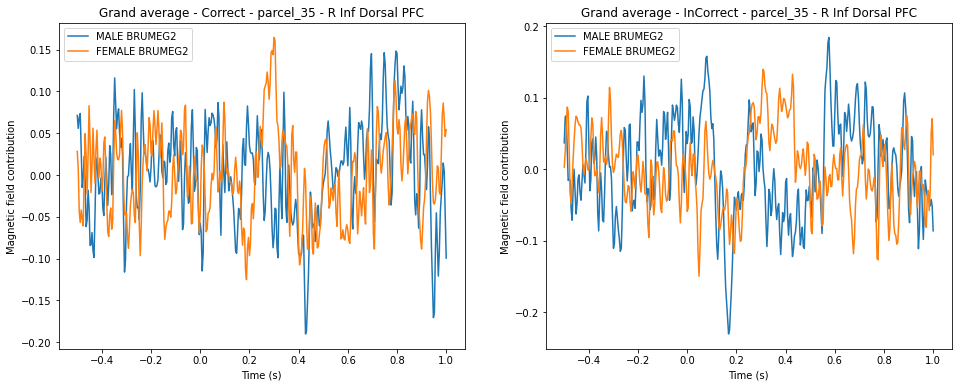

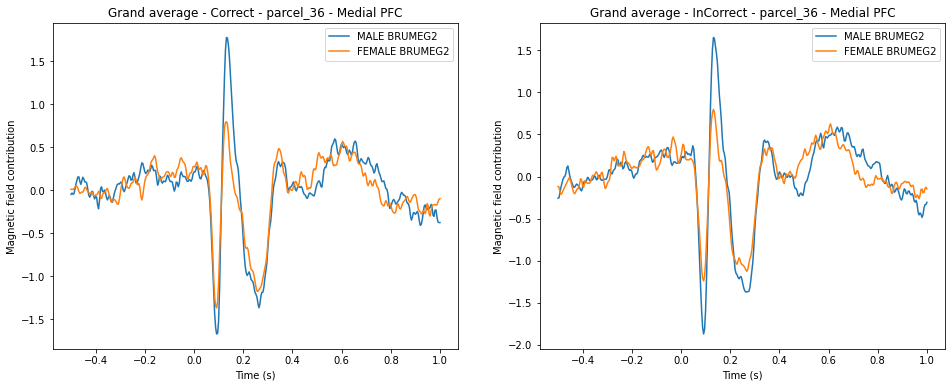

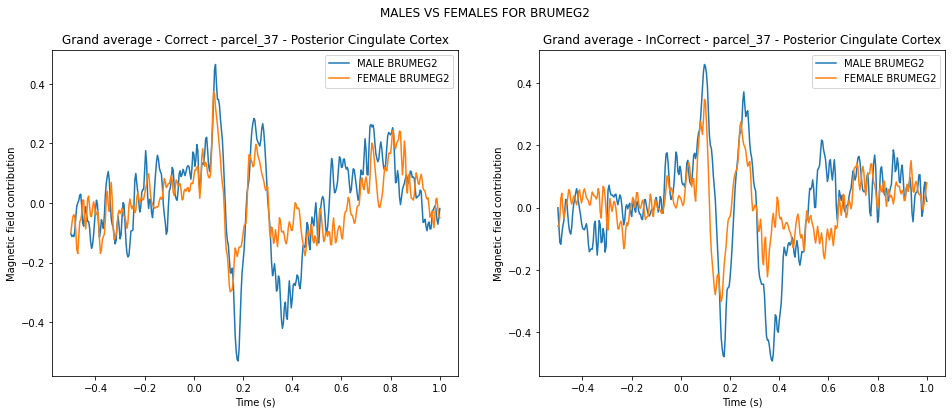

In [104]:
MALE_all_CORR_BRU1 = [epochs_AVG[male_idx][0] for male_idx in male_idx_brumeg_1]
MALE_all_INCORR_BRU1 = [epochs_AVG[male_idx][1] for male_idx in male_idx_brumeg_1]
MALE_all_CORR_BRU2 = [epochs_AVG[male_idx][0] for male_idx in male_idx_brumeg_2]
MALE_all_INCORR_BRU2 = [epochs_AVG[male_idx][1] for male_idx in male_idx_brumeg_2]

FEMALE_all_CORR_BRU1 = [epochs_AVG[female_idx][0] for female_idx in female_idx_brumeg_1]
FEMALE_all_INCORR_BRU1 = [epochs_AVG[female_idx][1] for female_idx in female_idx_brumeg_1]
FEMALE_all_CORR_BRU2 = [epochs_AVG[female_idx][0] for female_idx in female_idx_brumeg_2]
FEMALE_all_INCORR_BRU2 = [epochs_AVG[female_idx][1] for female_idx in female_idx_brumeg_2]
print(MALE_all_CORR_BRU1)
# Calculate the grand average

GA_MALE_CORR_BRU2 = mne.grand_average(MALE_all_CORR_BRU2).get_data()
GA_MALE_INCORR_BRU2 = mne.grand_average(MALE_all_INCORR_BRU2).get_data()
GA_FEMALE_CORR_BRU2 = mne.grand_average(FEMALE_all_CORR_BRU2).get_data()
GA_FEMALE_INCORR_BRU2 = mne.grand_average(FEMALE_all_INCORR_BRU2).get_data()

fs = 250
t_start = 0.5
t_end = 1
t = np.arange(-t_start,t_end+1/fs,1/fs)

for i in range(len(parcel_idx)):
    fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(16,6))
    #Correct
    axs[0].plot(t,GA_MALE_CORR_BRU2[i],label='MALE BRUMEG2')
    axs[0].plot(t,GA_FEMALE_CORR_BRU2[i],label='FEMALE BRUMEG2')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Magnetic field contribution')
    axs[0].legend()
    axs[0].set_title(f'Grand average - Correct - {parcel_idx[i]} - {parcel_names[i]}') 
    #Incorrect
    axs[1].plot(t,GA_MALE_INCORR_BRU2[i],label='MALE BRUMEG2')
    axs[1].plot(t,GA_FEMALE_INCORR_BRU2[i],label='FEMALE BRUMEG2')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Magnetic field contribution')
    axs[1].legend()
    axs[1].set_title(f'Grand average - InCorrect - {parcel_idx[i]} - {parcel_names[i]}') 
fig.suptitle('MALES VS FEMALES FOR BRUMEG2')

### PSD

In [105]:
# Start from "all_psds_brumeg2"
all_psds = np.concatenate([all_psds_brumeg1, all_psds_brumeg2])
male_PSDs = [all_psds[sub] for sub in male_idx_brumeg_2]
female_PSDs = [all_psds[sub] for sub in female_idx_brumeg_2]

print(len(male_PSDs))
print(len(female_PSDs))

34
43


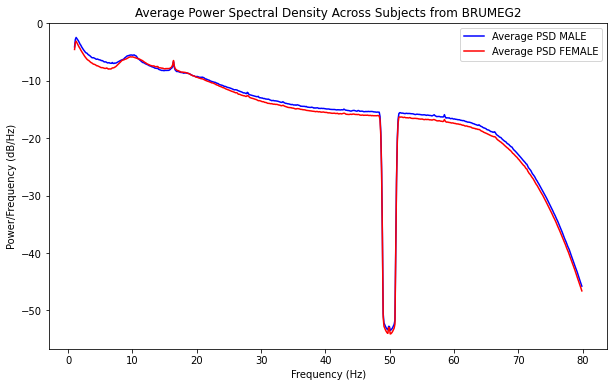

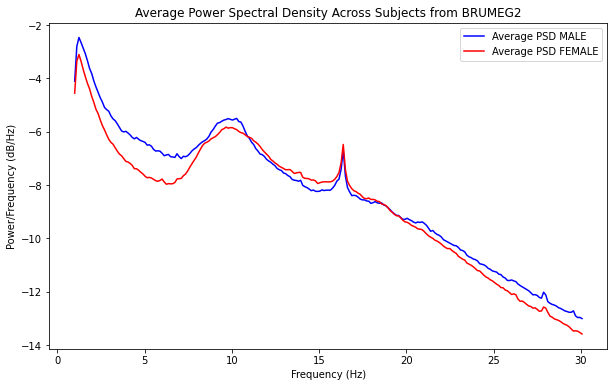

In [106]:
# Compute mean across subjects
mean_psd_male = np.mean(male_PSDs, axis=0)
mean_psd_female = np.mean(female_PSDs, axis=0)

# Plot the average PSD
freq_increment = np.shape(mean_psd_male)[1]
freqs = np.arange(1, 80 - 1/freq_increment, (80-1)/freq_increment)

plt.figure(figsize=(10, 6))
plt.plot(freqs, 10 * np.log10(np.mean(mean_psd_male,axis=0)), color='blue', label='Average PSD MALE')  # Convert to dB
plt.plot(freqs, 10 * np.log10(np.mean(mean_psd_female,axis=0)), color='red', label='Average PSD FEMALE')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Average Power Spectral Density Across Subjects from BRUMEG2')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(freqs[:239], 10 * np.log10(np.mean(mean_psd_male,axis=0))[:239], color='blue', label='Average PSD MALE')  # Convert to dB
plt.plot(freqs[:239], 10 * np.log10(np.mean(mean_psd_female,axis=0))[:239], color='red', label='Average PSD FEMALE')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Average Power Spectral Density Across Subjects from BRUMEG2')
plt.legend()
plt.show()